In [1]:
!nvidia-smi

Mon Jun 20 19:28:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')
INPUT_DIR = '/content/drive/MyDrive/Colab_Notebooks/us-patent-phrase-to-phrase-matching/'
OUTPUT_DIR = '/content/drive/MyDrive/kaggle/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd

import random

import os
import gc

import pickle

from tqdm.notebook import tqdm

from  sklearn.model_selection  import KFold, StratifiedKFold, StratifiedGroupKFold

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import torch
from torch import nn, optim
from torch.nn import functional as F
from  torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.io import read_image

import pickle

In [4]:
class CFG:
    VERSION = 54
    OUTPUT_DIR = '/content/drive/MyDrive/kaggle/'
    SEED = 10000
    seed = SEED
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    BATCH_SIZE = 256
    N_EPOCHS = 300
    num_fold = 5

In [5]:
print('DEVICE:', CFG.DEVICE)

DEVICE: cuda


In [6]:
if not os.path.exists(CFG.OUTPUT_DIR):
    os.makedirs(CFG.OUTPUT_DIR)

In [7]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(CFG.SEED)

In [8]:
df = pd.read_csv(INPUT_DIR+'train.csv')
df

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


In [9]:
def create_folds(data, num_splits, seed):
    sgk = StratifiedGroupKFold(n_splits=num_splits, shuffle=True, random_state=seed)

    for i, (trn_idx, val_idx) in enumerate(sgk.split(data['id'], data['score']*4, data['anchor'])):
        data.loc[val_idx, 'fold'] = i

    data['fold'] = data['fold'].astype(int)

    return data

In [10]:
# df = create_folds(df, CFG.num_fold, CFG.seed)[['id', 'score', 'fold']]
# display(df.head())
# display(df.groupby('fold').size())

# fig, ax = plt.subplots()
# for i in range(CFG.num_fold):
#   ax.hist(df.loc[df['fold']==i, 'score'], alpha=0.2, label=f'fold{i}')
# ax.legend()
# plt.show()

In [11]:
!pip install pickle5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
from sklearn.preprocessing import MinMaxScaler
import glob
import pickle5
version = CFG.VERSION

stacking_list = glob.glob('/content/drive/MyDrive/kaggle/oof_*.pkl')
print(stacking_list)
for i, oof_path in enumerate(tqdm(stacking_list)):
  with open(oof_path, "rb") as f:
    tmp = pickle5.load(f)[['id', 'pred']]
  tmp.columns = ['id', f'preds_{i}']
  df = pd.merge(df, tmp, on=['id'], how='left')
  score = np.corrcoef(df['score'], df[f'preds_{i}'])[0][1]
  print(f'cv{i}: {score}')

MMscaler = MinMaxScaler()

for col_name in [col for col in df.columns if 'preds_' in col]:
    df[col_name] = MMscaler.fit_transform(np.array(df[col_name]).reshape(-1,1)).reshape(-1)

df

['/content/drive/MyDrive/kaggle/oof_df_funnel_l_anchor.pkl', '/content/drive/MyDrive/kaggle/oof_df_pfp64_anchor.pkl', '/content/drive/MyDrive/kaggle/oof_df_deberta_l_v3_anchor.pkl', '/content/drive/MyDrive/kaggle/oof_df_electora-anchor.pkl', '/content/drive/MyDrive/kaggle/oof_df_bfp_anchor.pkl', '/content/drive/MyDrive/kaggle/oof_df-simcse-anchor.pkl']


  0%|          | 0/6 [00:00<?, ?it/s]

cv0: 0.818834329289873
cv1: 0.8208238238669177
cv2: 0.8272957039031479
cv3: 0.8288351571930295
cv4: 0.819532245330711
cv5: 0.8133072544803626


,id,anchor,target,context,score,preds_0,preds_1,preds_2,preds_3,preds_4,preds_5
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,0.466284,0.510132,0.317783,0.416120,0.462182,0.146545
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,0.722547,0.575757,0.713420,0.545296,0.637189,0.604272
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,0.117356,0.258999,0.243357,0.281782,0.258671,0.226358
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,0.549443,0.625390,0.510812,0.510402,0.562911,0.526696
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,0.021158,0.013692,0.044547,0.083340,0.087163,0.071804
...,...,...,...,...,...,...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00,0.993340,0.988504,0.983815,0.989919,0.977054,0.797394
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50,0.468818,0.495762,0.481736,0.503225,0.433811,0.400614
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50,0.473872,0.463800,0.445182,0.440896,0.384114,0.412725
36471,756ec035e694722b,wood article,wooden material,B44,0.75,0.733905,0.645317,0.709172,0.672722,0.642667,0.591164


In [13]:
feat_cols = [col for col in df.columns if 'preds_' in col]
target_col = 'score'

feat_cols

['preds_0', 'preds_1', 'preds_2', 'preds_3', 'preds_4', 'preds_5']

In [14]:
feat_cols_cnn = []

for i in range(10):
    feat_cols_cnn.append(random.sample(feat_cols, len(feat_cols)))

feat_cols_cnn

[['preds_4', 'preds_2', 'preds_0', 'preds_5', 'preds_3', 'preds_1'],
 ['preds_5', 'preds_0', 'preds_2', 'preds_3', 'preds_1', 'preds_4'],
 ['preds_0', 'preds_4', 'preds_3', 'preds_5', 'preds_1', 'preds_2'],
 ['preds_4', 'preds_1', 'preds_0', 'preds_5', 'preds_2', 'preds_3'],
 ['preds_5', 'preds_0', 'preds_4', 'preds_1', 'preds_3', 'preds_2'],
 ['preds_5', 'preds_1', 'preds_0', 'preds_4', 'preds_2', 'preds_3'],
 ['preds_2', 'preds_5', 'preds_3', 'preds_4', 'preds_1', 'preds_0'],
 ['preds_5', 'preds_4', 'preds_1', 'preds_0', 'preds_3', 'preds_2'],
 ['preds_4', 'preds_5', 'preds_3', 'preds_0', 'preds_1', 'preds_2'],
 ['preds_3', 'preds_0', 'preds_1', 'preds_4', 'preds_5', 'preds_2']]

In [15]:
pickle.dump(feat_cols_cnn, open(os.path.join(CFG.OUTPUT_DIR, 'feat_cols_cnn.pkl'), 'wb'))

In [16]:
feat_cols_cnn = pickle.load(open(os.path.join(CFG.OUTPUT_DIR, 'feat_cols_cnn.pkl'), 'rb'))

feat_cols_cnn

[['preds_4', 'preds_2', 'preds_0', 'preds_5', 'preds_3', 'preds_1'],
 ['preds_5', 'preds_0', 'preds_2', 'preds_3', 'preds_1', 'preds_4'],
 ['preds_0', 'preds_4', 'preds_3', 'preds_5', 'preds_1', 'preds_2'],
 ['preds_4', 'preds_1', 'preds_0', 'preds_5', 'preds_2', 'preds_3'],
 ['preds_5', 'preds_0', 'preds_4', 'preds_1', 'preds_3', 'preds_2'],
 ['preds_5', 'preds_1', 'preds_0', 'preds_4', 'preds_2', 'preds_3'],
 ['preds_2', 'preds_5', 'preds_3', 'preds_4', 'preds_1', 'preds_0'],
 ['preds_5', 'preds_4', 'preds_1', 'preds_0', 'preds_3', 'preds_2'],
 ['preds_4', 'preds_5', 'preds_3', 'preds_0', 'preds_1', 'preds_2'],
 ['preds_3', 'preds_0', 'preds_1', 'preds_4', 'preds_5', 'preds_2']]

# 0. Weight Optimization

In [ ]:
from scipy.optimize import minimize

In [ ]:
seed_everything(CFG.SEED)

In [ ]:
Y_values = df['score'].values
predictions = []
lls = []
wghts = []

In [ ]:
def corr_func(weights):
    ''' scipy minimize will pass the weights as a numpy array '''
    final_prediction = 0
    for weight, prediction in zip(weights, predictions):
            final_prediction += weight*prediction

    return 1- (np.corrcoef(final_prediction, Y_values)[0][1])

In [ ]:
for i in [col for col in df.columns if 'preds' in col]:
    predictions.append(np.array(df.loc[:, i]))

In [ ]:
%%time
# Optimization runs 10000 times.
for i in tqdm(range(10000)):
    starting_values = np.random.uniform(size=len([col for col in df.columns if 'preds' in col]))
   
    bounds = [(0,1)]*len(predictions)
    
    res = minimize(corr_func, starting_values, method='L-BFGS-B', 
                   bounds=bounds, options={'disp': False, 'maxiter': 100000})

    lls.append(res['fun'])
    wghts.append(res['x'])

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
bestSC = np.min(lls)
bestWght = wghts[np.argmin(lls)]

print('\n Ensemble Score: {best_score:.7f}'.format(best_score=1-bestSC))
print('\n Best Weights: {weights:}'.format(weights=bestWght))


 Ensemble Score: 0.8534993

 Best Weights: [0.29668871 0.51978457 0.79660916 0.62860518 0.41631683 0.87659641]


In [ ]:
bestWght

array([0.29668871, 0.51978457, 0.79660916, 0.62860518, 0.41631683,
       0.87659641])

In [ ]:
sum = bestWght.sum()
bestWght /= sum

bestWght

array([0.08393839, 0.14705609, 0.22537457, 0.17784333, 0.11778327,
       0.24800436])

In [ ]:
df['ensambled'] = 0
for i in range(len(bestWght)):
    df['ensambled'] = df['ensambled'] + df[f'preds_{i}'] * bestWght[i]

df

,id,anchor,target,context,score,preds_0,preds_1,preds_2,preds_3,preds_4,preds_5,ensambled
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,0.466284,0.510132,0.317783,0.416120,0.462182,0.146545,0.350563
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,0.722547,0.575757,0.713420,0.545296,0.637189,0.604272,0.627994
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,0.117356,0.258999,0.243357,0.281782,0.258671,0.226358,0.239503
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,0.549443,0.625390,0.510812,0.510402,0.562911,0.526696,0.540907
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,0.021158,0.013692,0.044547,0.083340,0.087163,0.071804,0.056725
...,...,...,...,...,...,...,...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00,0.993340,0.988504,0.983815,0.989919,0.977054,0.797394,0.939360
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50,0.468818,0.495762,0.481736,0.503225,0.433811,0.400614,0.460773
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50,0.473872,0.463800,0.445182,0.440896,0.384114,0.412725,0.434323
36471,756ec035e694722b,wood article,wooden material,B44,0.75,0.733905,0.645317,0.709172,0.672722,0.642667,0.591164,0.658276


In [ ]:
np.corrcoef(df['ensambled'], df['score'])[0][1]

0.853499317100389

In [ ]:
path = os.path.join(CFG.OUTPUT_DIR, 'WeightOptimizatin/best_weights.pkl')

if not os.path.exists(path):
    os.makedirs(path)

pickle.dump(bestWght, open(os.path.join(path, 'best_weights.pkl'), 'wb'))

In [ ]:
_bestWght = pickle.load(open(os.path.join(path, 'best_weights.pkl'), 'rb'))

all(bestWght == _bestWght)

True

# 1. MLP

In [ ]:
class StackingDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.feats = df[feat_cols].values
        self.target = df[target_col].values
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        feats = torch.tensor(self.feats[idx]).float()
        target = torch.tensor(self.target[idx]).float()

        d = {
            "feats": feats,
            "target" : target,
        }

        return d

In [ ]:
class StackingModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg

        self.linear0 = nn.Linear(len(feat_cols), 1024)
        self.dropout0 = nn.Dropout(0.2)
        self.linear1 = nn.Linear(1024, 256)
        self.dropout1 = nn.Dropout(0.2)
        self.linear2 = nn.Linear(256, 64)
        self.dropout2 = nn.Dropout(0.2)
        self.linear3 = nn.Linear(64, 1)
        
    def forward(self, feats, y=None):
        x = self.linear0(feats)
        x = torch.relu(x)
        x = self.dropout0(x)
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.dropout2(x)
        output = self.linear3(x)

        if y is None:
            loss = None
        else:
            loss = self.loss_fn(output, y)
            # loss = 0 - torch.corrcoef(torch.stack((output.reshape(-1), y.reshape(-1))))[0][1]

        return output, loss


    def loss_fn(self, y_pred, y_true):
        criterion = nn.BCEWithLogitsLoss()
        loss = criterion(y_pred.reshape(-1), y_true.reshape(-1))

        return loss

In [ ]:
def train_loop(model, optimizer, scheduler, loader):
    losses, lrs = [], []
    model.train()
    for d in loader:
        out, loss = model(d['feats'].to(CFG.DEVICE), d['target'].to(CFG.DEVICE))
        
        losses.append(loss.item())
        step_lrs = np.array([param_group["lr"] for param_group in optimizer.param_groups])
        lrs.extend(step_lrs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # scheduler.step()

    return np.array(losses).mean(), lrs


def valid_loop(model, loader):
    losses, predicts = [], []
    model.eval()
    for d in loader:
        with torch.no_grad():
            out, loss = model(d['feats'].to(CFG.DEVICE), d['target'].to(CFG.DEVICE))
        pred = torch.tensor(out.sigmoid())
        losses.append(loss.item())
        predicts.append(pred.cpu())

    return np.array(losses).mean(), torch.vstack(predicts).numpy().reshape(-1)

def test_loop(model, loader):
    predicts = []
    model.eval()
    for d in loader:
        with torch.no_grad():
            out, _ = model(d['feats'].to(CFG.DEVICE))
        pred = torch.tensor(out.sigmoid())
        predicts.append(pred.cpu())

    return torch.vstack(predicts).numpy().reshape(-1)

In [ ]:
# # https://www.kaggle.com/code/abhishek/phrase-matching-folds
# def create_folds(data, num_splits):
#     # we create a new column called kfold and fill it with -1
#     data["fold"] = -1
    
#     # the next step is to randomize the rows of the data
#     # data = data.sample(frac=1).reset_index(drop=True)

#     # calculate number of bins by Sturge's rule
#     # I take the floor of the value, you can also
#     # just round it
#     # num_bins = int(np.floor(1 + np.log2(len(data))))
    
#     # bin targets
#     data.loc[:, "bins"] = pd.cut(
#         data["score"], bins=5, labels=False
#     )
    
#     # initiate the kfold class from model_selection module
#     kf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=CFG.SEED)
    
#     # fill the new kfold column
#     # note that, instead of targets, we use bins!
#     for f, (t_, v_) in enumerate(kf.split(X=data, y=data.bins.values)):
#         data.loc[v_, 'fold'] = f
    
#     # drop the bins column
#     data = data.drop("bins", axis=1)

#     # return dataframe with folds
#     return data

--------------------
nn-0


,id,anchor,target,context,score,preds_0,preds_1,preds_2,preds_3,preds_4,preds_5,ensambled,fold
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,0.466284,0.510132,0.317783,0.416120,0.462182,0.146545,0.350563,2
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,0.722547,0.575757,0.713420,0.545296,0.637189,0.604272,0.627994,2
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,0.117356,0.258999,0.243357,0.281782,0.258671,0.226358,0.239503,2
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,0.549443,0.625390,0.510812,0.510402,0.562911,0.526696,0.540907,2
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,0.021158,0.013692,0.044547,0.083340,0.087163,0.071804,0.056725,2


fold
0    7273
1    7226
2    7516
3    7097
4    7361
dtype: int64

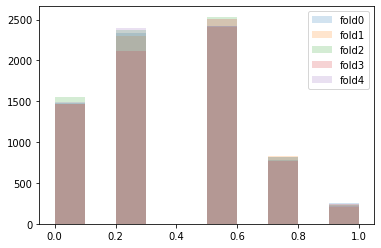

**********
fold-0
trainable parameters: 286081
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5473732425455462, val_loss:0.5304879484505489, val_score:0.8552438772630248

Epoch2　train_loss:0.5334065248046005, val_loss:0.5307107084784014, val_score:0.8547800960838126
    score did not impove from 0.8552438772630248 (now 1 consecutive)

Epoch 00003: reducing learning rate of group 0 to 5.0000e-04.
Epoch3　train_loss:0.532675465993714, val_loss:0.5296068088761692, val_score:0.8553047841967258

Epoch4　train_loss:0.532170357149944, val_loss:0.5295781349313671, val_score:0.8550444636186423
    score did not impove from 0.8553047841967258 (now 1 consecutive)

Epoch 00005: reducing learning rate of group 0 to 2.5000e-04.
Epoch5　train_loss:0.5319479816315467, val_loss:0.5292005785580339, val_score:0.8552482840058059
    score did not impove from 0.8553047841967258 (now 2 consecutive)

Epoch6　train_loss:0.5313852377105177, val_loss:0.529128426107867, val_score:0.8553575980517519

Epoch7　train_loss:0.5314922058268597, val_loss:0.5289837728286612, val_score:0.85564808332

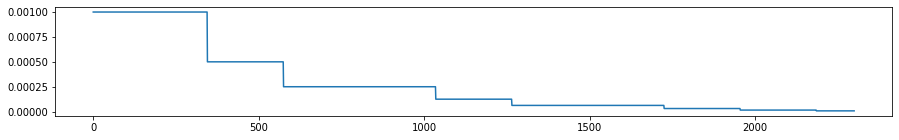


**********
fold-1
trainable parameters: 286081
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5466987038390678, val_loss:0.5316210635777178, val_score:0.8529587333006577

Epoch2　train_loss:0.5327019244432449, val_loss:0.5314536248815471, val_score:0.8535745435785242

Epoch3　train_loss:0.5324955180025938, val_loss:0.532440395190798, val_score:0.8501457723817333
    score did not impove from 0.8535745435785242 (now 1 consecutive)

Epoch 00004: reducing learning rate of group 0 to 5.0000e-04.
Epoch4　train_loss:0.5320410616042321, val_loss:0.5311436036537434, val_score:0.8530879495086214
    score did not impove from 0.8535745435785242 (now 2 consecutive)

Epoch5　train_loss:0.5314237143386874, val_loss:0.5300743405161232, val_score:0.8540255812520711

Epoch6　train_loss:0.5311848029755709, val_loss:0.5308121566114754, val_score:0.8537668349958528
    score did not impove from 0.8540255812520711 (now 1 consecutive)

Epoch 00007: reducing learning rate of group 0 to 2.5000e-04.
Epoch7　train_loss:0.5310999521037989, val_loss:0.5300785118135912, val_score:0.854100026

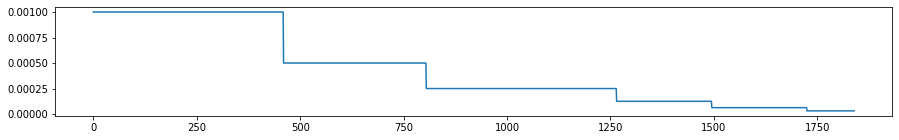


**********
fold-2
trainable parameters: 286081
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.547674268747853, val_loss:0.5313068081935247, val_score:0.849592139741394

Epoch2　train_loss:0.5336282833487587, val_loss:0.5322081128756205, val_score:0.8481646965815015
    score did not impove from 0.849592139741394 (now 1 consecutive)

Epoch3　train_loss:0.5325896223034479, val_loss:0.5300327112277349, val_score:0.8511888760631582

Epoch4　train_loss:0.532323516575636, val_loss:0.5297877967357636, val_score:0.8506076817243936
    score did not impove from 0.8511888760631582 (now 1 consecutive)

Epoch5　train_loss:0.5324596918262212, val_loss:0.5293586442867915, val_score:0.8517442006031472

Epoch6　train_loss:0.531792773082193, val_loss:0.5290656884511312, val_score:0.8520280789515591

Epoch7　train_loss:0.5319686608504405, val_loss:0.5303946187098821, val_score:0.8491049625691024
    score did not impove from 0.8520280789515591 (now 1 consecutive)

Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.
Epoch8　train_loss:0.5315379703466871, val_loss:0.52931936

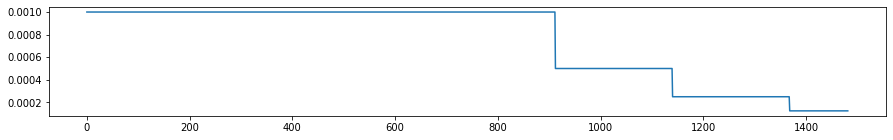


**********
fold-3
trainable parameters: 286081
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5469174646494681, val_loss:0.5302779440368924, val_score:0.8628823094243337

Epoch2　train_loss:0.5342182945786861, val_loss:0.5288014944110598, val_score:0.8642122134270876

Epoch3　train_loss:0.532652969945941, val_loss:0.528396728847708, val_score:0.8654113657180967

Epoch4　train_loss:0.5328577364745893, val_loss:0.5296434589794704, val_score:0.8646421644687353
    score did not impove from 0.8654113657180967 (now 1 consecutive)

Epoch 00005: reducing learning rate of group 0 to 5.0000e-04.
Epoch5　train_loss:0.5327594329913458, val_loss:0.5309489518404007, val_score:0.8646156688858913
    score did not impove from 0.8654113657180967 (now 2 consecutive)

Epoch6　train_loss:0.5320237731201607, val_loss:0.5279660118477685, val_score:0.8654114660382459

Epoch7　train_loss:0.5318672123708224, val_loss:0.5281153789588383, val_score:0.865517525413906

Epoch8　train_loss:0.5317280300353703, val_loss:0.5279457590409687, val_score:0.8654851340807753
    score did not impove fro

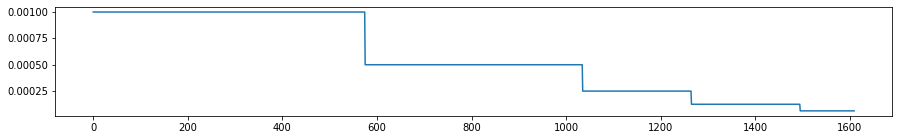


**********
fold-4
trainable parameters: 286081
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5435693205985348, val_loss:0.5366612323399248, val_score:0.8387028806664716

Epoch2　train_loss:0.5319336660667858, val_loss:0.535291406615027, val_score:0.8404670036680677

Epoch3　train_loss:0.5315166128947671, val_loss:0.5345029029352911, val_score:0.8420882851169399

Epoch4　train_loss:0.5311162258143973, val_loss:0.5350621507085603, val_score:0.8409729820491512
    score did not impove from 0.8420882851169399 (now 1 consecutive)

Epoch5　train_loss:0.5306474613932382, val_loss:0.5344810465286518, val_score:0.8428089262548031

Epoch6　train_loss:0.5309225239057457, val_loss:0.5344223585622064, val_score:0.8419900676882681
    score did not impove from 0.8428089262548031 (now 1 consecutive)

Epoch7　train_loss:0.5307003863617382, val_loss:0.5339135157650915, val_score:0.843707623426563

Epoch8　train_loss:0.5304153168623427, val_loss:0.5344212671806072, val_score:0.8437257784141109

Epoch9　train_loss:0.5302499326984439, val_loss:0.5339502260602754, val_score:0.843971490

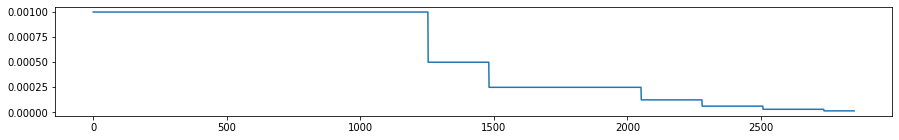


CV Score: 0.8542816298596968
--------------------
nn-1


,id,anchor,target,context,score,preds_0,preds_1,preds_2,preds_3,preds_4,preds_5,ensambled,fold
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,0.466284,0.510132,0.317783,0.416120,0.462182,0.146545,0.350563,0
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,0.722547,0.575757,0.713420,0.545296,0.637189,0.604272,0.627994,0
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,0.117356,0.258999,0.243357,0.281782,0.258671,0.226358,0.239503,0
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,0.549443,0.625390,0.510812,0.510402,0.562911,0.526696,0.540907,0
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,0.021158,0.013692,0.044547,0.083340,0.087163,0.071804,0.056725,0


fold
0    7620
1    6968
2    6969
3    6912
4    8004
dtype: int64

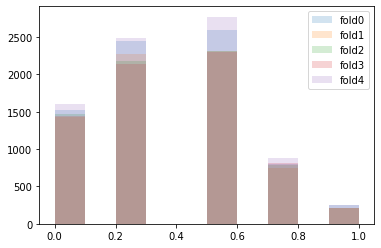

**********
fold-0
trainable parameters: 286081
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5462745361562286, val_loss:0.531513848900795, val_score:0.8561933557751866

Epoch2　train_loss:0.5335251774106707, val_loss:0.5326495011647542, val_score:0.857254611256883

Epoch3　train_loss:0.5323578824422189, val_loss:0.5320039947827657, val_score:0.8564061607126416
    score did not impove from 0.857254611256883 (now 1 consecutive)

Epoch4　train_loss:0.5324580126575061, val_loss:0.5304823140303294, val_score:0.8585621320060405

Epoch5　train_loss:0.5323720880384956, val_loss:0.5310062179962795, val_score:0.8569826973626504
    score did not impove from 0.8585621320060405 (now 1 consecutive)

Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.
Epoch6　train_loss:0.5321595788534198, val_loss:0.5306767851114274, val_score:0.8579144937271943
    score did not impove from 0.8585621320060405 (now 2 consecutive)

Epoch7　train_loss:0.5313241755855935, val_loss:0.5300172170003256, val_score:0.858600208031563

Epoch 00008: reducing learning rate of group 0 to 2.5000

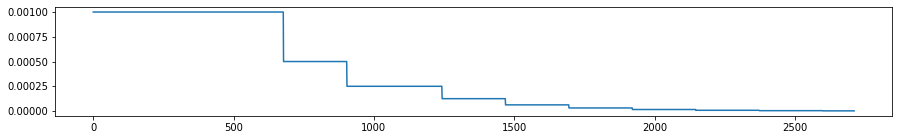


**********
fold-1
trainable parameters: 286081
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5454833567142486, val_loss:0.5309851116367749, val_score:0.8518578041962805

Epoch2　train_loss:0.5329193698323291, val_loss:0.5304804146289825, val_score:0.8521164073141775

Epoch3　train_loss:0.5322397397912066, val_loss:0.5303746547017779, val_score:0.8515548040105985
    score did not impove from 0.8521164073141775 (now 1 consecutive)

Epoch4　train_loss:0.5322786349317302, val_loss:0.5299865848251751, val_score:0.8522211002419183

Epoch5　train_loss:0.5317750658677972, val_loss:0.530608265527657, val_score:0.8512401521885091
    score did not impove from 0.8522211002419183 (now 1 consecutive)

Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.
Epoch6　train_loss:0.5318210213080696, val_loss:0.5309207471353667, val_score:0.8513841162378085
    score did not impove from 0.8522211002419183 (now 2 consecutive)

Epoch7　train_loss:0.5310867988544962, val_loss:0.5300316555159432, val_score:0.8522313822229427

Epoch 00008: reducing learning rate of group 0 to 2.5

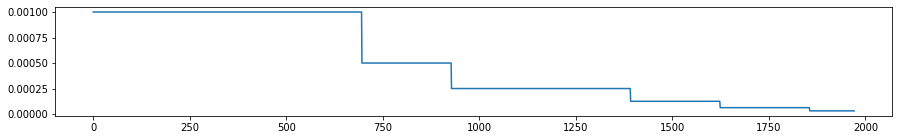


**********
fold-2
trainable parameters: 286081
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5451738308305326, val_loss:0.5328590827328819, val_score:0.8449398015445273

Epoch2　train_loss:0.533471811854321, val_loss:0.5354658152375903, val_score:0.846863343903646

Epoch3　train_loss:0.5329429426918859, val_loss:0.5307050102523395, val_score:0.8474697209611237

Epoch4　train_loss:0.5324542385080586, val_loss:0.5311531924775669, val_score:0.8470207963296865
    score did not impove from 0.8474697209611237 (now 1 consecutive)

Epoch 00005: reducing learning rate of group 0 to 5.0000e-04.
Epoch5　train_loss:0.5319371194943138, val_loss:0.5314983502030373, val_score:0.8471480236516543
    score did not impove from 0.8474697209611237 (now 2 consecutive)

Epoch6　train_loss:0.5316022297610408, val_loss:0.5305009282061032, val_score:0.8471244140298783
    score did not impove from 0.8474697209611237 (now 3 consecutive)

Epoch7　train_loss:0.531622166218965, val_loss:0.530980643417154, val_score:0.847783384678645

Epoch8　train_loss:0.5311864609303681, val_loss:0.53066469

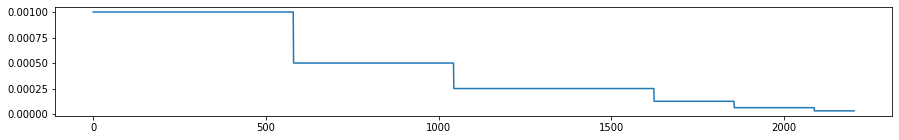


**********
fold-3
trainable parameters: 286081
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5475226676982382, val_loss:0.5287588073147668, val_score:0.8568387842095057

Epoch2　train_loss:0.5338430334692416, val_loss:0.5282939186802617, val_score:0.8575739590570193

Epoch3　train_loss:0.5330725190432175, val_loss:0.5269752641518911, val_score:0.858414568080168

Epoch4　train_loss:0.5329866391161214, val_loss:0.5284098199120274, val_score:0.8557380773661518
    score did not impove from 0.858414568080168 (now 1 consecutive)

Epoch 00005: reducing learning rate of group 0 to 5.0000e-04.
Epoch5　train_loss:0.5331503616726917, val_loss:0.5278609306723984, val_score:0.8569234072676324
    score did not impove from 0.858414568080168 (now 2 consecutive)

Epoch6　train_loss:0.5323934461759484, val_loss:0.5276039651146641, val_score:0.8575140091567472
    score did not impove from 0.858414568080168 (now 3 consecutive)

Epoch 00007: reducing learning rate of group 0 to 2.5000e-04.
Epoch7　train_loss:0.5319645060145337, val_loss:0.5270120004812876, val_score:0.858093087566

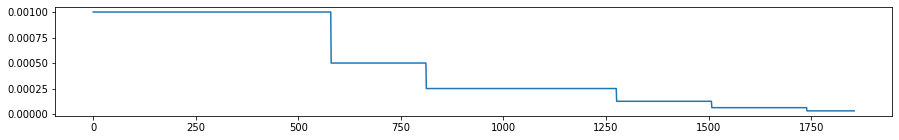


**********
fold-4
trainable parameters: 286081
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5448376106786298, val_loss:0.5356418592855334, val_score:0.8511675292835382

Epoch2　train_loss:0.5317284220510775, val_loss:0.5343811167404056, val_score:0.8528266528170589

Epoch3　train_loss:0.5310658981671205, val_loss:0.5355830537155271, val_score:0.8489823704342125
    score did not impove from 0.8528266528170589 (now 1 consecutive)

Epoch4　train_loss:0.5309841777827289, val_loss:0.5345649113878608, val_score:0.8530636667902475

Epoch5　train_loss:0.5306579196775282, val_loss:0.533494140021503, val_score:0.8531850976287135

Epoch6　train_loss:0.5308178357175879, val_loss:0.5335185555741191, val_score:0.8537899938257185

Epoch7　train_loss:0.5306248063439721, val_loss:0.5357282552868128, val_score:0.8538223519018984

Epoch8　train_loss:0.5309242858543052, val_loss:0.5340929636731744, val_score:0.8539549180893969

Epoch9　train_loss:0.5302579405608477, val_loss:0.5335969878360629, val_score:0.8530664470605601
    score did not impove from 0.8539549180893969 (now 1 cons

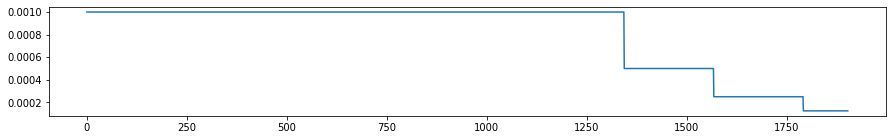


CV Score: 0.8541223510630883
--------------------
nn-2


,id,anchor,target,context,score,preds_0,preds_1,preds_2,preds_3,preds_4,preds_5,ensambled,fold
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,0.466284,0.510132,0.317783,0.416120,0.462182,0.146545,0.350563,0
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,0.722547,0.575757,0.713420,0.545296,0.637189,0.604272,0.627994,0
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,0.117356,0.258999,0.243357,0.281782,0.258671,0.226358,0.239503,0
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,0.549443,0.625390,0.510812,0.510402,0.562911,0.526696,0.540907,0
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,0.021158,0.013692,0.044547,0.083340,0.087163,0.071804,0.056725,0


fold
0    7500
1    7196
2    7131
3    7684
4    6962
dtype: int64

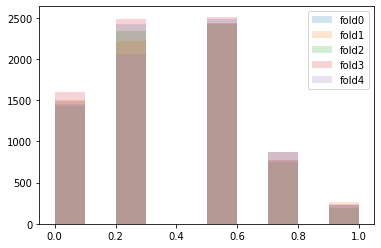

**********
fold-0
trainable parameters: 286081
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5452519394127668, val_loss:0.5371561169624328, val_score:0.8463905453427024

Epoch2　train_loss:0.5323050138169685, val_loss:0.5353565712769827, val_score:0.8481259086284844

Epoch3　train_loss:0.5310931920477774, val_loss:0.5362800280253093, val_score:0.8474273313384556
    score did not impove from 0.8481259086284844 (now 1 consecutive)

Epoch4　train_loss:0.5309385596650892, val_loss:0.5346249749263128, val_score:0.8491045294589425

Epoch5　train_loss:0.5309598575123643, val_loss:0.5345516681671143, val_score:0.8488774535028046
    score did not impove from 0.8491045294589425 (now 1 consecutive)

Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.
Epoch6　train_loss:0.5306588353308956, val_loss:0.5353000481923421, val_score:0.8479582873781369
    score did not impove from 0.8491045294589425 (now 2 consecutive)

Epoch7　train_loss:0.5303109662722697, val_loss:0.5345209399859111, val_score:0.8484995266738897
    score did not impove from 0.8491045294589425 (now

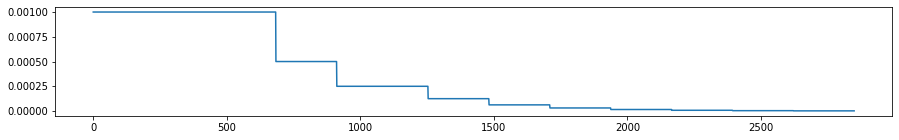


**********
fold-1
trainable parameters: 286081
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5522040829323885, val_loss:0.5246242480031376, val_score:0.8639826121451144

Epoch2　train_loss:0.5351002135297709, val_loss:0.5232375294997774, val_score:0.8648802361686665

Epoch3　train_loss:0.5341416837876303, val_loss:0.5247284143135466, val_score:0.8644279863091204
    score did not impove from 0.8648802361686665 (now 1 consecutive)

Epoch 00004: reducing learning rate of group 0 to 5.0000e-04.
Epoch4　train_loss:0.5341623561424121, val_loss:0.5231134028270327, val_score:0.8635255417526085
    score did not impove from 0.8648802361686665 (now 2 consecutive)

Epoch5　train_loss:0.5333262164341775, val_loss:0.522196291849531, val_score:0.8660102551467803

Epoch6　train_loss:0.533047126050581, val_loss:0.5222002493924108, val_score:0.8660512420875889

Epoch 00007: reducing learning rate of group 0 to 2.5000e-04.
Epoch7　train_loss:0.532974909794958, val_loss:0.5223500430583954, val_score:0.8656925044914809
    score did not impove from 0.8660512420875889 (now 1 consecu

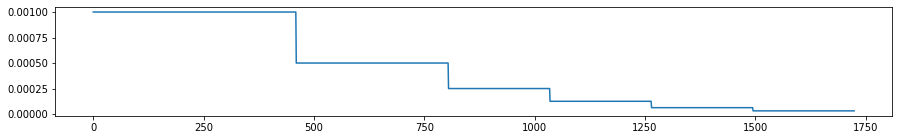


**********
fold-2
trainable parameters: 286081
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5463157029528367, val_loss:0.5368491240910122, val_score:0.8460927351677562

Epoch2　train_loss:0.532741889096143, val_loss:0.5349320833172116, val_score:0.8478611978204645

Epoch3　train_loss:0.5315789857454467, val_loss:0.5354175652776446, val_score:0.8471315223667998
    score did not impove from 0.8478611978204645 (now 1 consecutive)

Epoch 00004: reducing learning rate of group 0 to 5.0000e-04.
Epoch4　train_loss:0.5313551561874256, val_loss:0.5361620613506862, val_score:0.8477280733646778
    score did not impove from 0.8478611978204645 (now 2 consecutive)

Epoch5　train_loss:0.530684107751177, val_loss:0.5348564812115261, val_score:0.8487444547961605

Epoch6　train_loss:0.530583896135029, val_loss:0.5347195054803576, val_score:0.8484019992572005
    score did not impove from 0.8487444547961605 (now 1 consecutive)

Epoch 00007: reducing learning rate of group 0 to 2.5000e-04.
Epoch7　train_loss:0.5304075780144909, val_loss:0.5345582855599267, val_score:0.84858569671

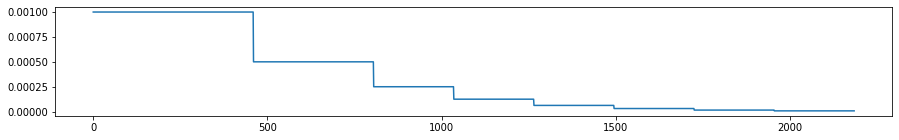


**********
fold-3
trainable parameters: 286081
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.547782648886953, val_loss:0.5276432152717344, val_score:0.8519655103071873

Epoch2　train_loss:0.5339761434921196, val_loss:0.527065404961186, val_score:0.8529530757253032

Epoch3　train_loss:0.5335567886275905, val_loss:0.5273500113717972, val_score:0.8524058785283106
    score did not impove from 0.8529530757253032 (now 1 consecutive)

Epoch 00004: reducing learning rate of group 0 to 5.0000e-04.
Epoch4　train_loss:0.5324624114270721, val_loss:0.526635516074396, val_score:0.8519389544110817
    score did not impove from 0.8529530757253032 (now 2 consecutive)

Epoch5　train_loss:0.5320926175585815, val_loss:0.5264884300770298, val_score:0.8531132608534092

Epoch6　train_loss:0.5319524718714612, val_loss:0.527885906157955, val_score:0.8524777645487056
    score did not impove from 0.8531132608534092 (now 1 consecutive)

Epoch 00007: reducing learning rate of group 0 to 2.5000e-04.
Epoch7　train_loss:0.5323161349764892, val_loss:0.5269155021636717, val_score:0.852877395085

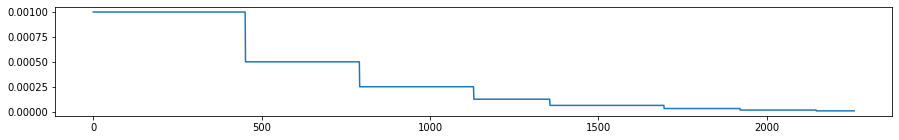


**********
fold-4
trainable parameters: 286081
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5515746036301489, val_loss:0.5306094629423959, val_score:0.8505804926653496

Epoch2　train_loss:0.5339264449865921, val_loss:0.529605898473944, val_score:0.852240596845969

Epoch3　train_loss:0.5329809746016627, val_loss:0.5330375305243901, val_score:0.8501846173726151
    score did not impove from 0.852240596845969 (now 1 consecutive)

Epoch 00004: reducing learning rate of group 0 to 5.0000e-04.
Epoch4　train_loss:0.5322487424249235, val_loss:0.5320827599082675, val_score:0.8516693068038189
    score did not impove from 0.852240596845969 (now 2 consecutive)

Epoch5　train_loss:0.5316029022569242, val_loss:0.5286473972456796, val_score:0.8532519938322745

Epoch6　train_loss:0.5315688076226608, val_loss:0.5293256597859519, val_score:0.8524208308304925
    score did not impove from 0.8532519938322745 (now 1 consecutive)

Epoch 00007: reducing learning rate of group 0 to 2.5000e-04.
Epoch7　train_loss:0.5318718827289084, val_loss:0.5289358496665955, val_score:0.852641772362

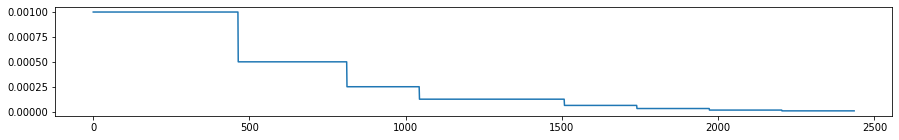


CV Score: 0.8539917331574485
--------------------
nn-3


,id,anchor,target,context,score,preds_0,preds_1,preds_2,preds_3,preds_4,preds_5,ensambled,fold
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,0.466284,0.510132,0.317783,0.416120,0.462182,0.146545,0.350563,0
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,0.722547,0.575757,0.713420,0.545296,0.637189,0.604272,0.627994,0
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,0.117356,0.258999,0.243357,0.281782,0.258671,0.226358,0.239503,0
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,0.549443,0.625390,0.510812,0.510402,0.562911,0.526696,0.540907,0
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,0.021158,0.013692,0.044547,0.083340,0.087163,0.071804,0.056725,0


fold
0    7454
1    7040
2    7571
3    7377
4    7031
dtype: int64

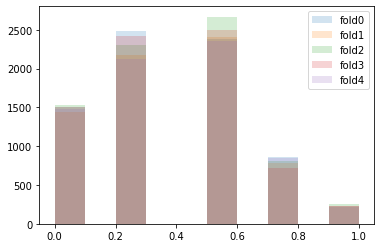

**********
fold-0
trainable parameters: 286081
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5452647391146264, val_loss:0.5361379315455754, val_score:0.8397736491234982

Epoch2　train_loss:0.53217743376715, val_loss:0.5353703598181406, val_score:0.8408173668706177

Epoch3　train_loss:0.5311343712089336, val_loss:0.5363516688346863, val_score:0.8372256481656755
    score did not impove from 0.8408173668706177 (now 1 consecutive)

Epoch 00004: reducing learning rate of group 0 to 5.0000e-04.
Epoch4　train_loss:0.5306769830990682, val_loss:0.5356364329655965, val_score:0.8407368777640877
    score did not impove from 0.8408173668706177 (now 2 consecutive)

Epoch5　train_loss:0.5303118199901243, val_loss:0.5350316007932027, val_score:0.8415172541718698

Epoch6　train_loss:0.530712178850596, val_loss:0.5356927802165349, val_score:0.8412035663786879
    score did not impove from 0.8415172541718698 (now 1 consecutive)

Epoch 00007: reducing learning rate of group 0 to 2.5000e-04.
Epoch7　train_loss:0.530067383188062, val_loss:0.5353907843430837, val_score:0.841078865883

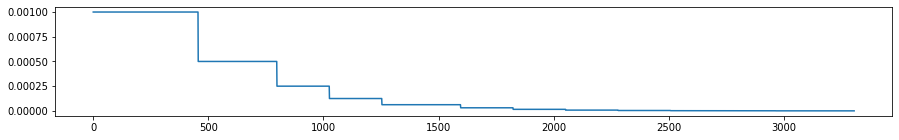


**********
fold-1
trainable parameters: 286081
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5463122071927053, val_loss:0.5351567225796836, val_score:0.8535428909038921

Epoch2　train_loss:0.5335778264622939, val_loss:0.5342595960412707, val_score:0.8538614115960269

Epoch3　train_loss:0.5331252308791143, val_loss:0.5324449645621436, val_score:0.8552862480215134

Epoch4　train_loss:0.5320820761354346, val_loss:0.5315918858562197, val_score:0.8549316765323192
    score did not impove from 0.8552862480215134 (now 1 consecutive)

Epoch 00005: reducing learning rate of group 0 to 5.0000e-04.
Epoch5　train_loss:0.5321954917489436, val_loss:0.5323793483631951, val_score:0.8539237656701567
    score did not impove from 0.8552862480215134 (now 2 consecutive)

Epoch6　train_loss:0.5319415427613676, val_loss:0.5309731332319123, val_score:0.8554368940905299

Epoch7　train_loss:0.5309291048008099, val_loss:0.531539785010474, val_score:0.8543720346781745
    score did not impove from 0.8554368940905299 (now 1 consecutive)

Epoch 00008: reducing learning rate of group 0 to 2.5

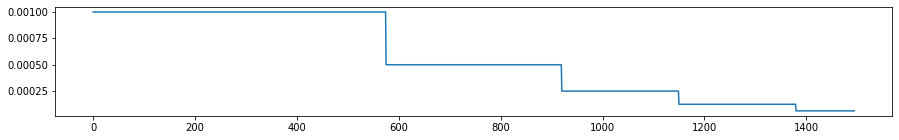


**********
fold-2
trainable parameters: 286081
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5474314194704805, val_loss:0.5333023250102997, val_score:0.8541932166744496

Epoch2　train_loss:0.5329331792891026, val_loss:0.5323667883872986, val_score:0.8540604348292454
    score did not impove from 0.8541932166744496 (now 1 consecutive)

Epoch3　train_loss:0.5322155486792326, val_loss:0.5321324020624161, val_score:0.8551016052362356

Epoch4　train_loss:0.5325681742812906, val_loss:0.5322216580311457, val_score:0.8544566089680741
    score did not impove from 0.8551016052362356 (now 1 consecutive)

Epoch5　train_loss:0.5318269953131676, val_loss:0.5317801753679912, val_score:0.8554593539795875

Epoch6　train_loss:0.531533121796591, val_loss:0.5331806798775991, val_score:0.8531433921218964
    score did not impove from 0.8554593539795875 (now 1 consecutive)

Epoch 00007: reducing learning rate of group 0 to 5.0000e-04.
Epoch7　train_loss:0.5311713623149055, val_loss:0.5342239459355672, val_score:0.85220300374359
    score did not impove from 0.8554593539795875 (now 2 

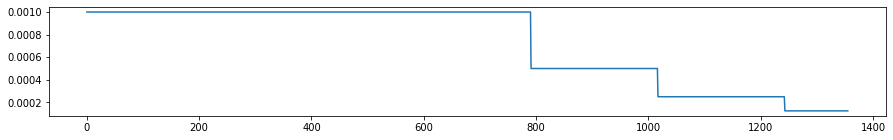


**********
fold-3
trainable parameters: 286081
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5465759516289804, val_loss:0.5287926680055158, val_score:0.8619333296875838

Epoch2　train_loss:0.5341058776969403, val_loss:0.5259501276345089, val_score:0.8640875072563269

Epoch3　train_loss:0.534260478694882, val_loss:0.5298616824478939, val_score:0.8606917142578675
    score did not impove from 0.8640875072563269 (now 1 consecutive)

Epoch4　train_loss:0.5336849375636177, val_loss:0.5262053249211147, val_score:0.8646100825492231

Epoch5　train_loss:0.533420229643847, val_loss:0.5256785729835773, val_score:0.8648810767293347

Epoch6　train_loss:0.5330081642728991, val_loss:0.5253984157381386, val_score:0.8653085956813862

Epoch7　train_loss:0.5331142916616085, val_loss:0.5256986813298588, val_score:0.8649852684947577
    score did not impove from 0.8653085956813862 (now 1 consecutive)

Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.
Epoch8　train_loss:0.533084704812649, val_loss:0.5254210922224768, val_score:0.863954938136095
    score did not impove from

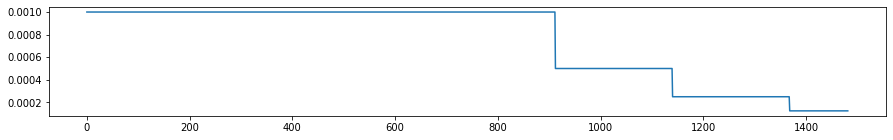


**********
fold-4
trainable parameters: 286081
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5456055845903314, val_loss:0.5322210788726807, val_score:0.8509717910416617

Epoch2　train_loss:0.5337169014889261, val_loss:0.532649570277759, val_score:0.8511158351866429

Epoch3　train_loss:0.5328593129697053, val_loss:0.5308388737695557, val_score:0.8524727269800222

Epoch4　train_loss:0.5324693200380906, val_loss:0.5311098716088704, val_score:0.8526677456634882

Epoch5　train_loss:0.5321909207364787, val_loss:0.5315630989415305, val_score:0.8519562443772755
    score did not impove from 0.8526677456634882 (now 1 consecutive)

Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.
Epoch6　train_loss:0.5321066312167956, val_loss:0.531664314014571, val_score:0.8514687516280011
    score did not impove from 0.8526677456634882 (now 2 consecutive)

Epoch7　train_loss:0.5315900460533474, val_loss:0.5306694805622101, val_score:0.852541500930564
    score did not impove from 0.8526677456634882 (now 3 consecutive)

Epoch8　train_loss:0.5311420881229898, val_loss:0.530654

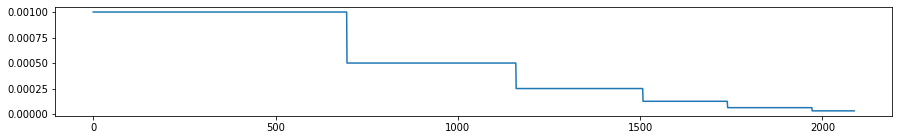


CV Score: 0.8538487731984649
--------------------
nn-4


,id,anchor,target,context,score,preds_0,preds_1,preds_2,preds_3,preds_4,preds_5,ensambled,fold
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,0.466284,0.510132,0.317783,0.416120,0.462182,0.146545,0.350563,4
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,0.722547,0.575757,0.713420,0.545296,0.637189,0.604272,0.627994,4
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,0.117356,0.258999,0.243357,0.281782,0.258671,0.226358,0.239503,4
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,0.549443,0.625390,0.510812,0.510402,0.562911,0.526696,0.540907,4
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,0.021158,0.013692,0.044547,0.083340,0.087163,0.071804,0.056725,4


fold
0    7292
1    7260
2    7371
3    7139
4    7411
dtype: int64

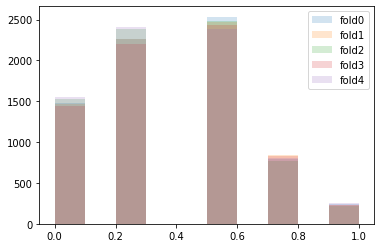

**********
fold-0
trainable parameters: 286081
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5450723841127041, val_loss:0.534201745329232, val_score:0.8507094863095187

Epoch2　train_loss:0.53243970739103, val_loss:0.5333578494088403, val_score:0.8516434785606156

Epoch3　train_loss:0.5318259459681216, val_loss:0.5333965996216083, val_score:0.851642969488718
    score did not impove from 0.8516434785606156 (now 1 consecutive)

Epoch4　train_loss:0.5319996017270383, val_loss:0.5337080215585643, val_score:0.851954141105005

Epoch5　train_loss:0.5315948885626498, val_loss:0.5359298329928825, val_score:0.8484904650317925
    score did not impove from 0.851954141105005 (now 1 consecutive)

Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.
Epoch6　train_loss:0.5313040466435188, val_loss:0.5335603335808063, val_score:0.8508677216575421
    score did not impove from 0.851954141105005 (now 2 consecutive)

Epoch7　train_loss:0.5308676238081097, val_loss:0.5329549271484901, val_score:0.8517870871809237
    score did not impove from 0.851954141105005 (now 3 conse

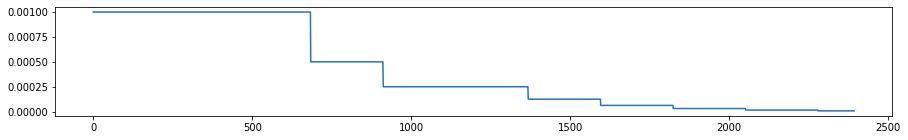


**********
fold-1
trainable parameters: 286081
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5457977385897386, val_loss:0.5350229185203026, val_score:0.8624112392932309

Epoch2　train_loss:0.5334241494797823, val_loss:0.5323438551919214, val_score:0.8635932778061015

Epoch3　train_loss:0.5322155319807822, val_loss:0.5330377755493954, val_score:0.8617945976243194
    score did not impove from 0.8635932778061015 (now 1 consecutive)

Epoch 00004: reducing learning rate of group 0 to 5.0000e-04.
Epoch4　train_loss:0.5322455599119789, val_loss:0.5318959077884411, val_score:0.863469297960473
    score did not impove from 0.8635932778061015 (now 2 consecutive)

Epoch5　train_loss:0.53150424230517, val_loss:0.5326405640306144, val_score:0.8624686138159887
    score did not impove from 0.8635932778061015 (now 3 consecutive)

Epoch 00006: reducing learning rate of group 0 to 2.5000e-04.
Epoch6　train_loss:0.531113678948921, val_loss:0.532358218883646, val_score:0.8634026860261517
    score did not impove from 0.8635932778061015 (now 4 consecutive)

Epoch7　train_loss:0.530

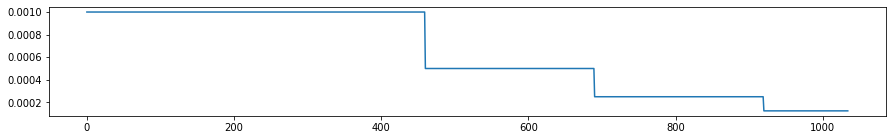


**********
fold-2
trainable parameters: 286081
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5491503706548067, val_loss:0.5325084667781304, val_score:0.8549846538770705

Epoch2　train_loss:0.5349782554976708, val_loss:0.5282742041966011, val_score:0.8568816545099641

Epoch3　train_loss:0.5338752317217599, val_loss:0.5277058924066609, val_score:0.8574098461186397

Epoch4　train_loss:0.5329784613794986, val_loss:0.5272030409040123, val_score:0.8581516819622549

Epoch5　train_loss:0.5331116434747138, val_loss:0.5272970220138287, val_score:0.8585490933104376

Epoch6　train_loss:0.5330030628010235, val_loss:0.5267523948488564, val_score:0.8587463975695008

Epoch7　train_loss:0.5323156896418175, val_loss:0.5270618508602011, val_score:0.8583314754872658
    score did not impove from 0.8587463975695008 (now 1 consecutive)

Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.
Epoch8　train_loss:0.5322319324565145, val_loss:0.5270022513537571, val_score:0.8585621538043311
    score did not impove from 0.8587463975695008 (now 2 consecutive)

Epoch9　train_loss:0.5319

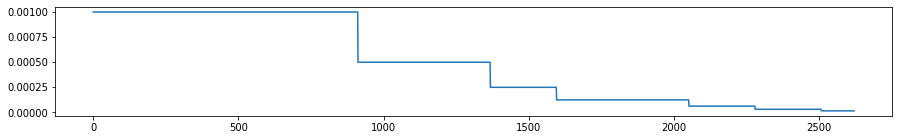


**********
fold-3
trainable parameters: 286081
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5430073455760354, val_loss:0.5343634464911052, val_score:0.8505193774875686

Epoch2　train_loss:0.5330164931845247, val_loss:0.5341522821358272, val_score:0.8516048111988483

Epoch3　train_loss:0.5320297584199069, val_loss:0.532896417592253, val_score:0.8521625740337713

Epoch4　train_loss:0.5317817892421756, val_loss:0.5329827410834176, val_score:0.8516745546456422
    score did not impove from 0.8521625740337713 (now 1 consecutive)

Epoch 00005: reducing learning rate of group 0 to 5.0000e-04.
Epoch5　train_loss:0.5313095839922888, val_loss:0.5327617653778621, val_score:0.8521407118201698
    score did not impove from 0.8521625740337713 (now 2 consecutive)

Epoch6　train_loss:0.5306683112131921, val_loss:0.5343806073069572, val_score:0.8519631186968442
    score did not impove from 0.8521625740337713 (now 3 consecutive)

Epoch 00007: reducing learning rate of group 0 to 2.5000e-04.
Epoch7　train_loss:0.5303440303133246, val_loss:0.5333707172955785, val_score:0.851168148

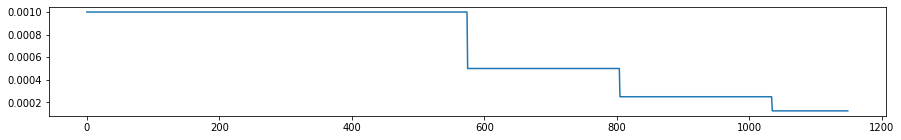


**********
fold-4
trainable parameters: 286081
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5538176124074817, val_loss:0.5323005832474808, val_score:0.8408088748238132

Epoch2　train_loss:0.5344909039218869, val_loss:0.5300198947561199, val_score:0.8436651453517702

Epoch3　train_loss:0.5333986672679935, val_loss:0.5289991939889973, val_score:0.8447222962012357

Epoch4　train_loss:0.5329966956535271, val_loss:0.5288572876617826, val_score:0.8441594081950723
    score did not impove from 0.8447222962012357 (now 1 consecutive)

Epoch 00005: reducing learning rate of group 0 to 5.0000e-04.
Epoch5　train_loss:0.5325401755033341, val_loss:0.5290755896732725, val_score:0.844371879237089
    score did not impove from 0.8447222962012357 (now 2 consecutive)

Epoch6　train_loss:0.5318919343758474, val_loss:0.5288139006187176, val_score:0.8450344292712215

Epoch7　train_loss:0.5318464085591578, val_loss:0.5285190199983532, val_score:0.8447476076641238
    score did not impove from 0.8450344292712215 (now 1 consecutive)

Epoch 00008: reducing learning rate of group 0 to 2.5

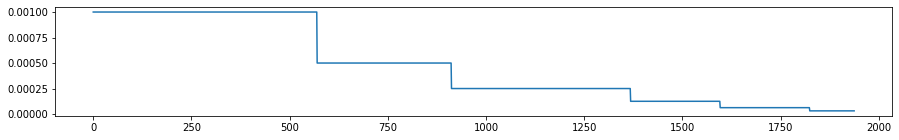


CV Score: 0.8542937327987611


In [ ]:
df_oof = df.copy()

for i in range(5):

    print('--'*10)
    print(f'nn-{i}')

    CFG.seed += 1

    path = os.path.join(CFG.OUTPUT_DIR, f'STACKING_seed{CFG.seed}_MODEL/')

    if not os.path.exists(path):
        os.makedirs(path)

    df = create_folds(df, CFG.num_fold, CFG.seed)
    display(df.head())
    display(df.groupby('fold').size())

    fig, ax = plt.subplots()
    for i in range(CFG.num_fold):
      ax.hist(df.loc[df['fold']==i, 'score'], alpha=0.2, label=f'fold{i}')
    ax.legend()
    plt.show()

    for fold in range(CFG.num_fold):

        print('*'*10)
        print(f'fold-{fold}')

        train = df[df['fold']!=fold]
        valid = df[df['fold']==fold]
        
        oof = np.zeros(len(train))
        test_preds_lst = []

        train_dset = StackingDataset(train)
        valid_dset = StackingDataset(valid)

        train_loader = DataLoader(train_dset, batch_size=CFG.BATCH_SIZE, pin_memory=True, shuffle=True, drop_last=True, num_workers=os.cpu_count())
        valid_loader = DataLoader(valid_dset, batch_size=CFG.BATCH_SIZE, pin_memory=True, shuffle=False, drop_last=False, num_workers=os.cpu_count())

        model = StackingModel(CFG)
        model.to(CFG.DEVICE)

        model_path = os.path.join(path, f'base_fold{fold}.bin')

        trainable_num = 0
        untrainable_num = 0
        for p in model.parameters():
            if p.requires_grad:
                trainable_num += p.numel()
            else:
                untrainable_num += p.numel()
                
        print(f'trainable parameters: {trainable_num}')
        print(f'untrainable parameters: {untrainable_num}')
        
        optimizer = torch.optim.AdamW(model.parameters())
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, verbose=True)
                    
        valid_best_score = float('-999')
        counter = 0

        lr_list = []

        for epoch in tqdm(range(CFG.N_EPOCHS)):
            train_loss, lrs = train_loop(model, optimizer, scheduler, train_loader)
            valid_loss, valid_predict = valid_loop(model, valid_loader)

            valid['oof'] = valid_predict

            val_score = np.corrcoef(valid['oof'], valid[target_col])[0][1]

            scheduler.step(val_score)

            print(f'Epoch{epoch+1}　train_loss:{train_loss}, val_loss:{valid_loss}, val_score:{val_score}')

            if val_score > valid_best_score:
                valid_best_score = val_score
                counter = 0
                torch.save(model.state_dict(), model_path)

            else:
                counter += 1
                print(f'    score did not impove from {valid_best_score} (now {counter} consecutive)')

            # plt.figure(figsize=(15, 2))
            # plt.plot(lrs)
            # plt.show()

            lr_list.append(np.mean(lrs))
            lr_list.extend(lrs)

            print('')

            torch.cuda.empty_cache()
            gc.collect()

            if counter > 6:
              print(f'Fold{fold} Epoch{epoch+1} Early Stopping')
              print(f'best_score: {valid_best_score}')
              print('')
              break
        
        print(f'Fold{fold} best_score: {valid_best_score}')

        plt.figure(figsize=(15, 2))
        plt.plot(lr_list)
        plt.show()
        print('')

        model.load_state_dict(torch.load(model_path))
        df_oof.loc[df['fold']==fold, f'oof'] = test_loop(model, valid_loader)

    score = np.corrcoef(df_oof['oof'], df_oof[target_col])[0][1]

    print(f'CV Score: {score}')

In [ ]:
df_oof.to_pickle('mlp.pkl')

# 2. LightGBM

In [ ]:
import numpy as np
import pandas as pd

import random

import os
import gc

import pickle

from tqdm.notebook import tqdm

from  sklearn.model_selection  import KFold, StratifiedKFold, StratifiedGroupKFold

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import torch
from torch import nn, optim
from torch.nn import functional as F
from  torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.io import read_image

import lightgbm as lgb
# import optuna.integration.lightgbm as lgb

In [ ]:
def pearson_loss(preds: np.ndarray, data: lgb.Dataset):
  score = np.corrcoef(preds, data.get_label())[0][1]
  return 'pearson_loss', score, True

--------------------
nn-0


,id,anchor,target,context,score,preds_0,preds_1,preds_2,preds_3,preds_4,preds_5,fold
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,0.466284,0.510132,0.317783,0.416120,0.462182,0.146545,2
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,0.722547,0.575757,0.713420,0.545296,0.637189,0.604272,2
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,0.117356,0.258999,0.243357,0.281782,0.258671,0.226358,2
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,0.549443,0.625390,0.510812,0.510402,0.562911,0.526696,2
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,0.021158,0.013692,0.044547,0.083340,0.087163,0.071804,2


fold
0    7273
1    7226
2    7516
3    7097
4    7361
dtype: int64

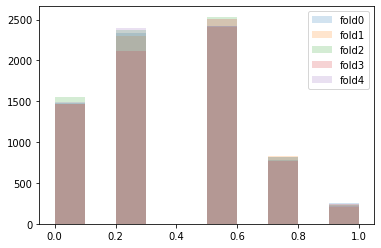

**********
fold-0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's pearson_loss: 0.853911
[200]	valid_0's pearson_loss: 0.853943
Early stopping, best iteration is:
[148]	valid_0's pearson_loss: 0.854071


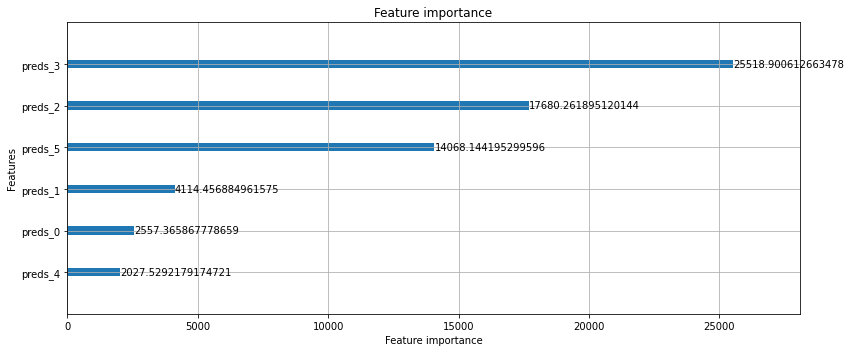

**********
fold-1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's pearson_loss: 0.853109
Early stopping, best iteration is:
[97]	valid_0's pearson_loss: 0.853131


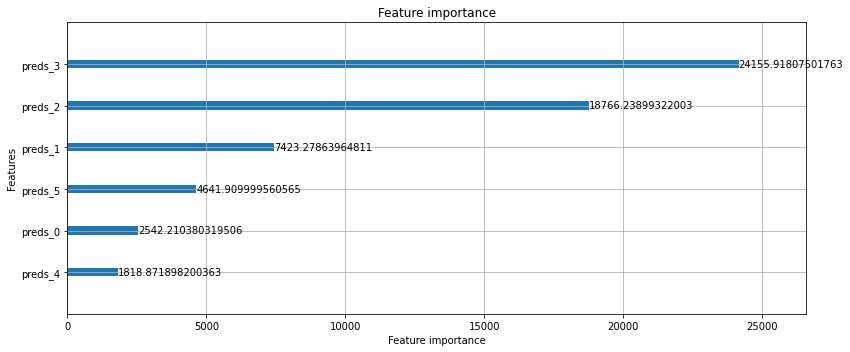

**********
fold-2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's pearson_loss: 0.850548
[200]	valid_0's pearson_loss: 0.850487
Early stopping, best iteration is:
[132]	valid_0's pearson_loss: 0.850672


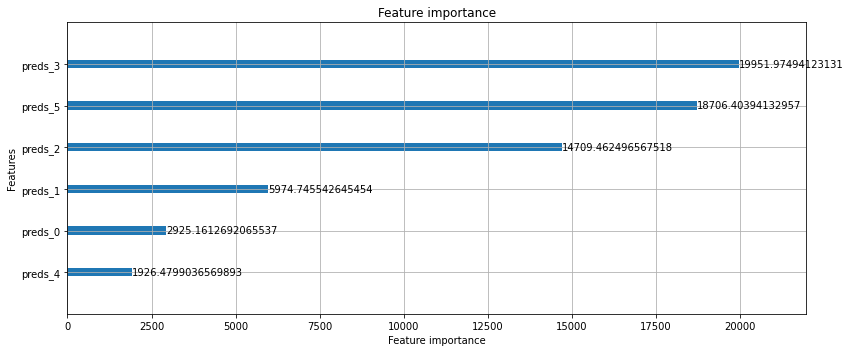

**********
fold-3
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's pearson_loss: 0.864213
[200]	valid_0's pearson_loss: 0.864211
Early stopping, best iteration is:
[181]	valid_0's pearson_loss: 0.864277


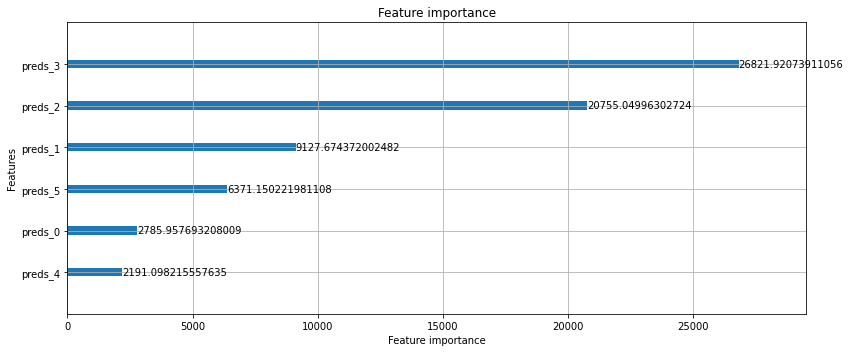

**********
fold-4
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's pearson_loss: 0.843526
Early stopping, best iteration is:
[61]	valid_0's pearson_loss: 0.843697


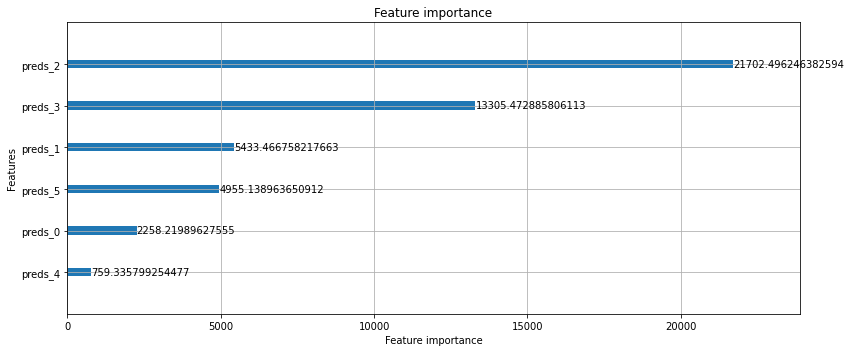

CV Score: 0.8530216894610273
--------------------
nn-1


,id,anchor,target,context,score,preds_0,preds_1,preds_2,preds_3,preds_4,preds_5,fold
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,0.466284,0.510132,0.317783,0.416120,0.462182,0.146545,0
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,0.722547,0.575757,0.713420,0.545296,0.637189,0.604272,0
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,0.117356,0.258999,0.243357,0.281782,0.258671,0.226358,0
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,0.549443,0.625390,0.510812,0.510402,0.562911,0.526696,0
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,0.021158,0.013692,0.044547,0.083340,0.087163,0.071804,0


fold
0    7620
1    6968
2    6969
3    6912
4    8004
dtype: int64

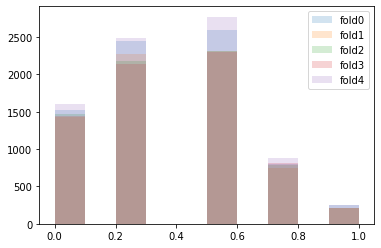

**********
fold-0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's pearson_loss: 0.856824
[200]	valid_0's pearson_loss: 0.857046
Early stopping, best iteration is:
[194]	valid_0's pearson_loss: 0.857056


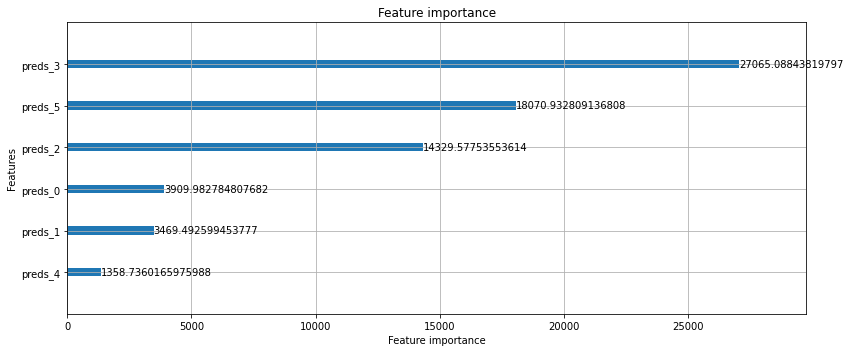

**********
fold-1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's pearson_loss: 0.85216
[200]	valid_0's pearson_loss: 0.852127
Early stopping, best iteration is:
[140]	valid_0's pearson_loss: 0.852413


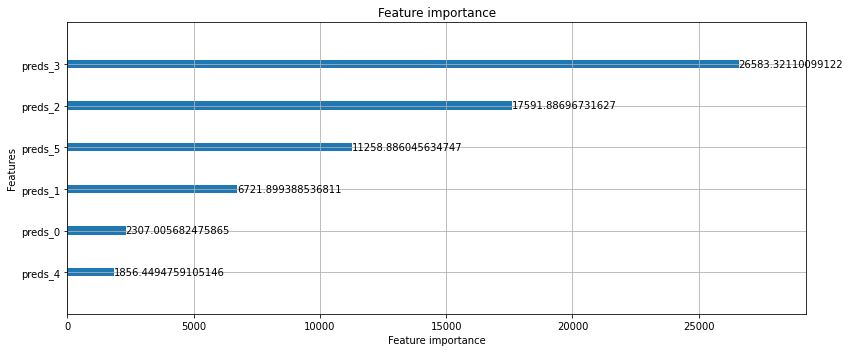

**********
fold-2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's pearson_loss: 0.846419
Early stopping, best iteration is:
[70]	valid_0's pearson_loss: 0.846573


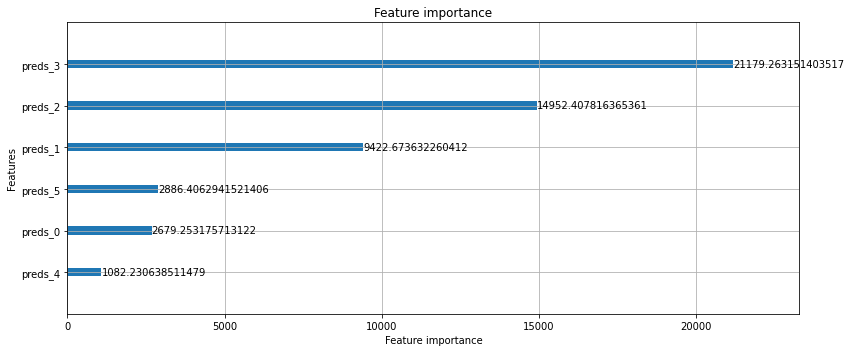

**********
fold-3
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's pearson_loss: 0.856485
[200]	valid_0's pearson_loss: 0.856609
Early stopping, best iteration is:
[143]	valid_0's pearson_loss: 0.856757


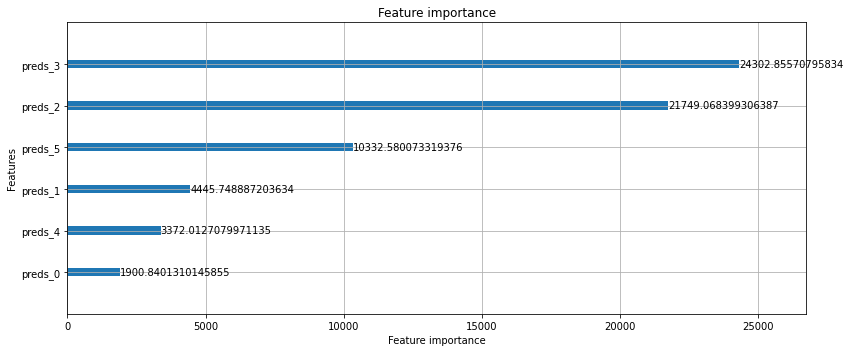

**********
fold-4
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's pearson_loss: 0.852925
Early stopping, best iteration is:
[94]	valid_0's pearson_loss: 0.852968


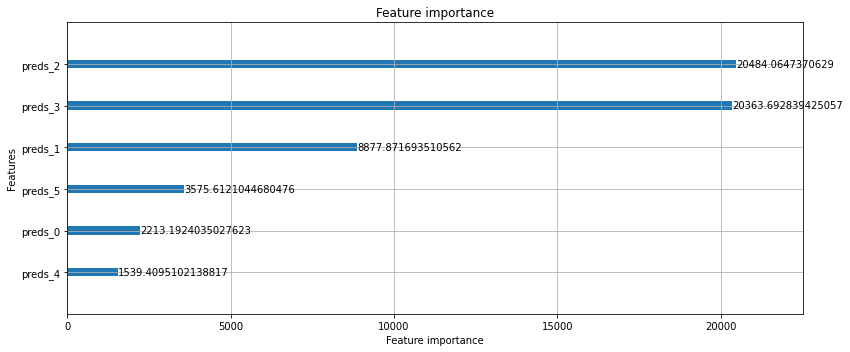

CV Score: 0.8530857252352778
--------------------
nn-2


,id,anchor,target,context,score,preds_0,preds_1,preds_2,preds_3,preds_4,preds_5,fold
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,0.466284,0.510132,0.317783,0.416120,0.462182,0.146545,0
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,0.722547,0.575757,0.713420,0.545296,0.637189,0.604272,0
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,0.117356,0.258999,0.243357,0.281782,0.258671,0.226358,0
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,0.549443,0.625390,0.510812,0.510402,0.562911,0.526696,0
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,0.021158,0.013692,0.044547,0.083340,0.087163,0.071804,0


fold
0    7500
1    7196
2    7131
3    7684
4    6962
dtype: int64

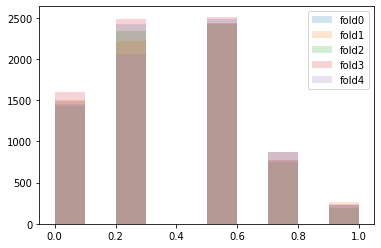

**********
fold-0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's pearson_loss: 0.848744
Early stopping, best iteration is:
[60]	valid_0's pearson_loss: 0.848891


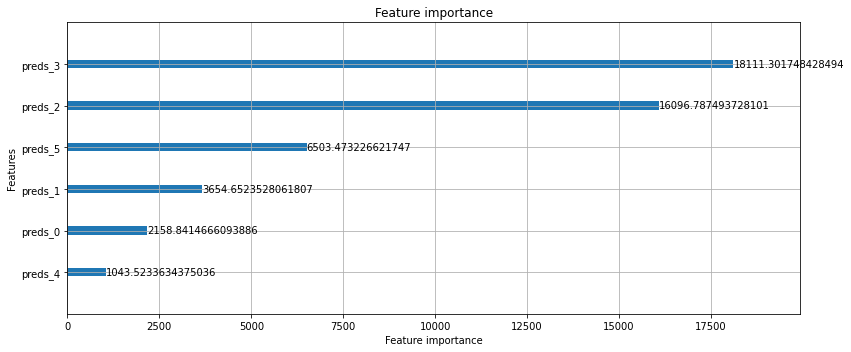

**********
fold-1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's pearson_loss: 0.864551
[200]	valid_0's pearson_loss: 0.864411
Early stopping, best iteration is:
[136]	valid_0's pearson_loss: 0.864636


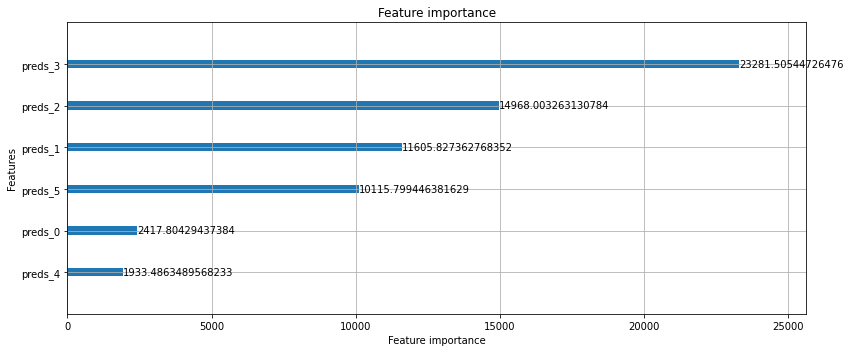

**********
fold-2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's pearson_loss: 0.847566
[200]	valid_0's pearson_loss: 0.847488
Early stopping, best iteration is:
[143]	valid_0's pearson_loss: 0.847622


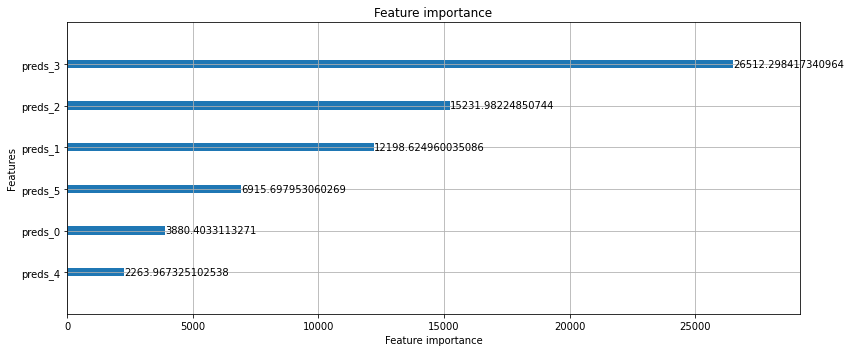

**********
fold-3
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's pearson_loss: 0.852415
Early stopping, best iteration is:
[63]	valid_0's pearson_loss: 0.852501


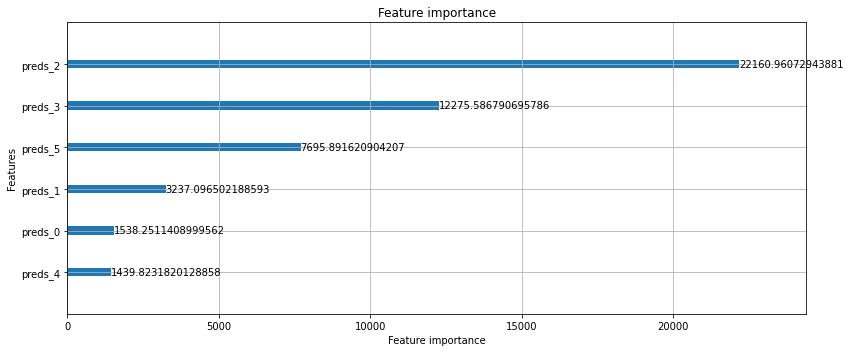

**********
fold-4
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's pearson_loss: 0.852819
Early stopping, best iteration is:
[64]	valid_0's pearson_loss: 0.853008


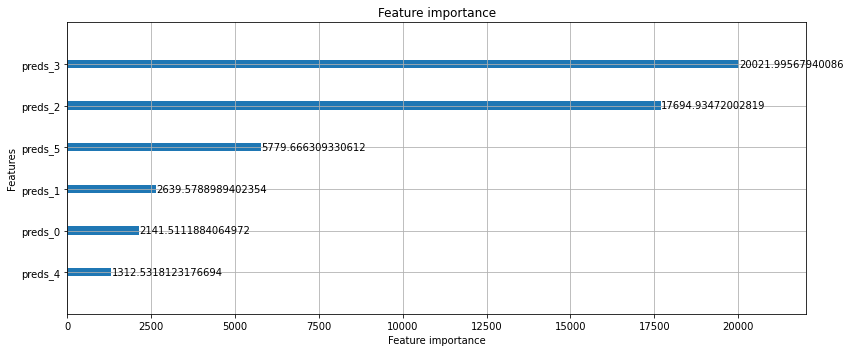

CV Score: 0.853238318298969
--------------------
nn-3


,id,anchor,target,context,score,preds_0,preds_1,preds_2,preds_3,preds_4,preds_5,fold
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,0.466284,0.510132,0.317783,0.416120,0.462182,0.146545,0
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,0.722547,0.575757,0.713420,0.545296,0.637189,0.604272,0
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,0.117356,0.258999,0.243357,0.281782,0.258671,0.226358,0
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,0.549443,0.625390,0.510812,0.510402,0.562911,0.526696,0
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,0.021158,0.013692,0.044547,0.083340,0.087163,0.071804,0


fold
0    7454
1    7040
2    7571
3    7377
4    7031
dtype: int64

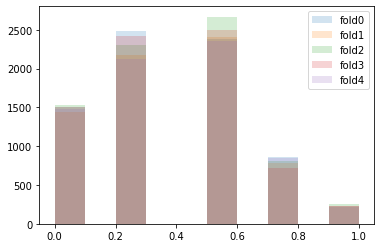

**********
fold-0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's pearson_loss: 0.841463
[200]	valid_0's pearson_loss: 0.841383
Early stopping, best iteration is:
[150]	valid_0's pearson_loss: 0.841542


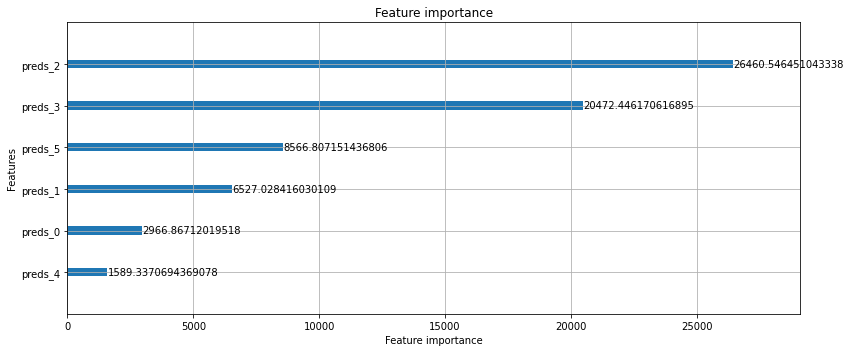

**********
fold-1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's pearson_loss: 0.854445
Early stopping, best iteration is:
[67]	valid_0's pearson_loss: 0.85464


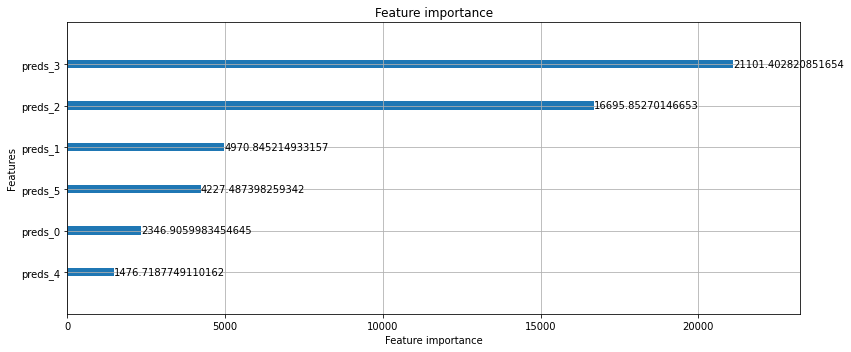

**********
fold-2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's pearson_loss: 0.853301
[200]	valid_0's pearson_loss: 0.853529
Early stopping, best iteration is:
[178]	valid_0's pearson_loss: 0.853606


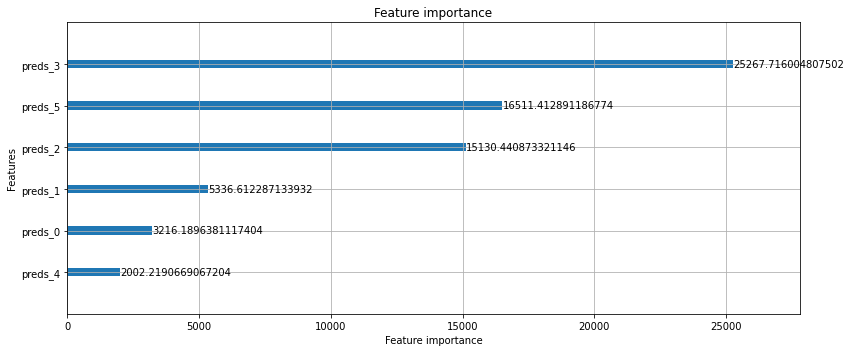

**********
fold-3
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's pearson_loss: 0.863528
Early stopping, best iteration is:
[84]	valid_0's pearson_loss: 0.863609


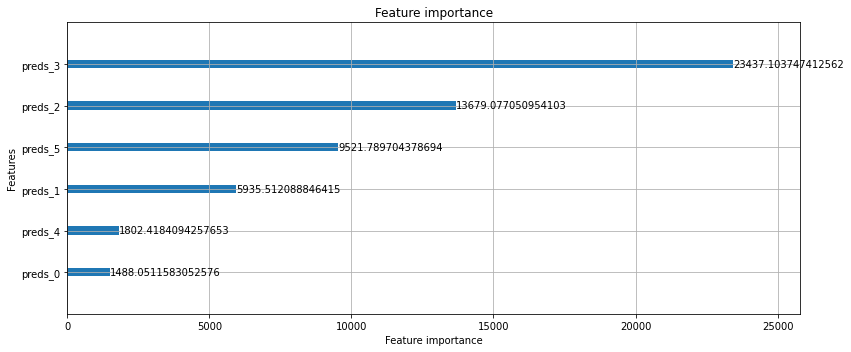

**********
fold-4
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's pearson_loss: 0.852146
[200]	valid_0's pearson_loss: 0.85196
Early stopping, best iteration is:
[160]	valid_0's pearson_loss: 0.852153


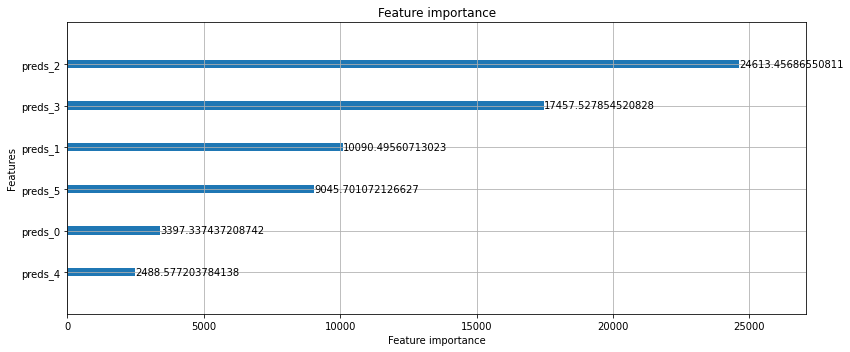

CV Score: 0.8530302267920963
--------------------
nn-4


,id,anchor,target,context,score,preds_0,preds_1,preds_2,preds_3,preds_4,preds_5,fold
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,0.466284,0.510132,0.317783,0.416120,0.462182,0.146545,4
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,0.722547,0.575757,0.713420,0.545296,0.637189,0.604272,4
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,0.117356,0.258999,0.243357,0.281782,0.258671,0.226358,4
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,0.549443,0.625390,0.510812,0.510402,0.562911,0.526696,4
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,0.021158,0.013692,0.044547,0.083340,0.087163,0.071804,4


fold
0    7292
1    7260
2    7371
3    7139
4    7411
dtype: int64

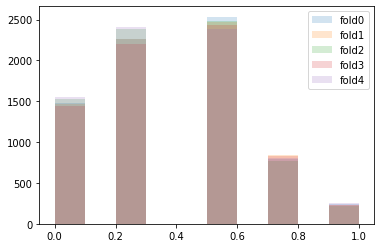

**********
fold-0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's pearson_loss: 0.850889
[200]	valid_0's pearson_loss: 0.850893
Early stopping, best iteration is:
[137]	valid_0's pearson_loss: 0.851029


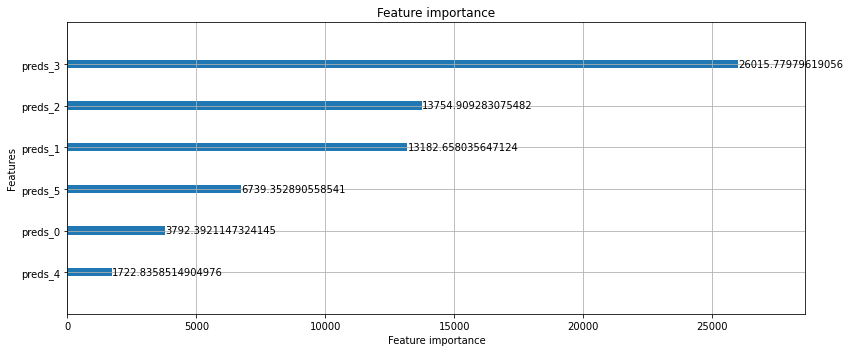

**********
fold-1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's pearson_loss: 0.862234
Early stopping, best iteration is:
[18]	valid_0's pearson_loss: 0.862755


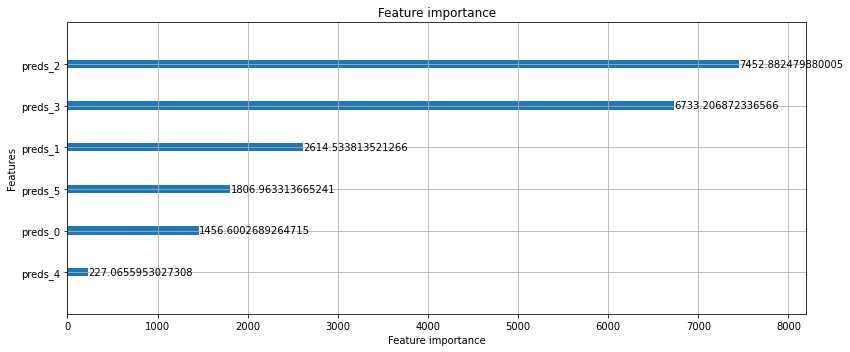

**********
fold-2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's pearson_loss: 0.857807
[200]	valid_0's pearson_loss: 0.857787
Early stopping, best iteration is:
[161]	valid_0's pearson_loss: 0.857921


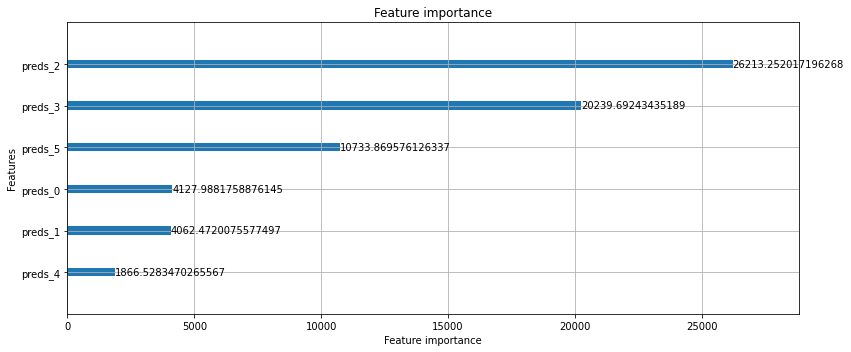

**********
fold-3
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's pearson_loss: 0.850932
Early stopping, best iteration is:
[60]	valid_0's pearson_loss: 0.850998


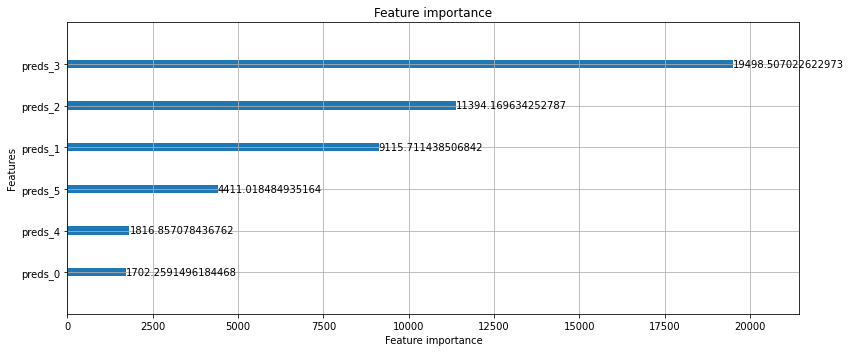

**********
fold-4
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's pearson_loss: 0.843333
[200]	valid_0's pearson_loss: 0.843402
Early stopping, best iteration is:
[138]	valid_0's pearson_loss: 0.843551


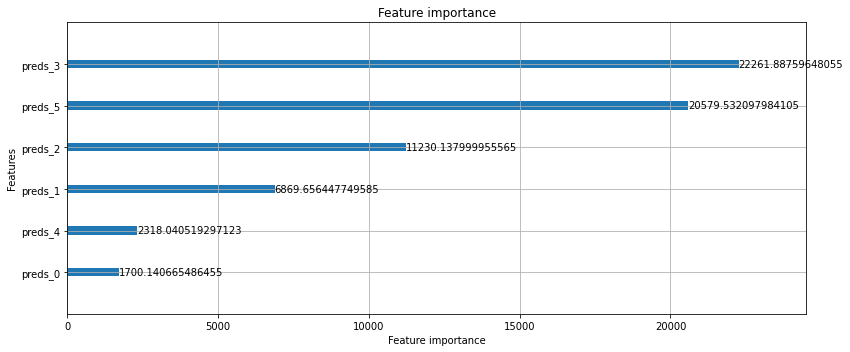

CV Score: 0.8530103036634469


In [ ]:
df_oof = df.copy()

for i in range(5):

    print('--'*10)
    print(f'nn-{i}')

    CFG.seed += 1

    path = os.path.join(CFG.OUTPUT_DIR, f'STACKING_seed{CFG.seed}_MODEL/')

    if not os.path.exists(path):
        os.makedirs(path)

    df = create_folds(df, CFG.num_fold, CFG.seed)
    display(df.head())
    display(df.groupby('fold').size())

    fig, ax = plt.subplots()
    for i in range(CFG.num_fold):
      ax.hist(df.loc[df['fold']==i, 'score'], alpha=0.2, label=f'fold{i}')
    ax.legend()
    plt.show()

    for fold in range(CFG.num_fold):

        print('*'*10)
        print(f'fold-{fold}')

        train = df[df['fold']!=fold]
        valid = df[df['fold']==fold]
        
        oof = np.zeros(len(train))
        test_preds_lst = []

        X_train, y_train = train[feat_cols], train[target_col]
        X_valid, y_valid = valid[feat_cols], valid[target_col]

        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_valid, y_valid)

        params = {
            'learning_rate': 0.01,
            "objective": "regression",
            "metric": "None",
            'boosting_type': "gbdt",
            'verbosity': 100,
            'n_jobs': -1, 
            'seed': CFG.SEED,
            'lambda_l1': 0.1, 
            'lambda_l2': 10, 
            'num_leaves': 128, 
            'subsample': 0.8,
            'feature_fraction': 0.8, 
            'bagging_fraction': 0.95, 
            'bagging_freq': 1, 
            'n_estimators': 1000000, 
            'max_depth': -1, 
            # 'max_bin': 494, 
            # 'min_data_in_leaf': 16
        }

        model_path = path

        lgb_model = lgb.train(
                                params,
                                lgb_train,
                                valid_sets=lgb_eval,
                                early_stopping_rounds=100,
                                verbose_eval=100,
                                feval=pearson_loss
                              )

            
        lgb.plot_importance(lgb_model, figsize=(12, 5), max_num_features=50, importance_type='gain')
        plt.tight_layout()
        plt.show()

        # model_path = os.path.join(CFG.BASE_DIR, 'MODEL/LGB/')
        if not os.path.exists(model_path):
            !mkdir -p {model_path}

        pickle.dump(lgb_model, open(os.path.join(model_path, f'lgb_model_fold{fold}_seed{CFG.seed}.pkl'), 'wb'))

        del lgb_model
        gc.collect()

        lgb_model = pickle.load(open(os.path.join(model_path, f'lgb_model_fold{fold}_seed{CFG.seed}.pkl'), 'rb'))

        df_oof.loc[df['fold']==fold, f'oof'] = MMscaler.fit_transform(np.array(lgb_model.predict(X_valid)).reshape(-1,1)).reshape(-1)

    score = np.corrcoef(df_oof['oof'], df_oof[target_col])[0][1]
    df_oof.to_pickle('lgbm.pkl')
    print(f'CV Score: {score}')

# 3. 1dcnn

In [22]:
class StackingDataset_1Dcnn(Dataset):
    def __init__(self, df, feat_cols):
        self.df = df
        self.feats = df[feat_cols].values.reshape(-1, len(stacking_list), 1)
        self.target = df[target_col].values
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        feats = torch.tensor(self.feats[idx]).float()
        target = torch.tensor(self.target[idx]).float()

        d = {
            "feats": feats,
            "target" : target,
        }

        return d

In [23]:
class StackingModel_1Dcnn(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg


        self.cnn1 = nn.Conv1d(len(stacking_list), 256, kernel_size=3, padding=1)
        self.cnn2 = nn.Conv1d(256, 1024, kernel_size=3, padding=1)

        self.linear0 = nn.Linear(1024, 1024)
        self.dropout0 = nn.Dropout(0.2)
        self.linear1 = nn.Linear(1024, 1)
        
    def forward(self, feats, y=None):
        x = self.cnn1(feats)
        x = torch.relu(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        
        x = torch.nn.Flatten()(x)
        
        x = self.linear0(x)
        x = torch.relu(x)
        x = self.dropout0(x)
        output = self.linear1(x)

        if y is None:
            loss = None
        else:
            loss = self.loss_fn(output, y)
            # loss = 0 - torch.corrcoef(torch.stack((output.reshape(-1), y.reshape(-1))))[0][1]

        return output, loss


    def loss_fn(self, y_pred, y_true):
        criterion = nn.BCEWithLogitsLoss()
        loss = criterion(y_pred.reshape(-1), y_true.reshape(-1))

        return loss

In [24]:
def train_loop(model, optimizer, scheduler, loader):
    losses, lrs = [], []
    model.train()
    for d in loader:
        out, loss = model(d['feats'].to(CFG.DEVICE), d['target'].to(CFG.DEVICE))
        
        losses.append(loss.item())
        step_lrs = np.array([param_group["lr"] for param_group in optimizer.param_groups])
        lrs.extend(step_lrs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # scheduler.step()

    return np.array(losses).mean(), lrs


def valid_loop(model, loader):
    losses, predicts = [], []
    model.eval()
    for d in loader:
        with torch.no_grad():
            out, loss = model(d['feats'].to(CFG.DEVICE), d['target'].to(CFG.DEVICE))
        pred = torch.tensor(out.sigmoid())
        losses.append(loss.item())
        predicts.append(pred.cpu())

    return np.array(losses).mean(), torch.vstack(predicts).numpy().reshape(-1)

def test_loop(model, loader):
    predicts = []
    model.eval()
    for d in loader:
        with torch.no_grad():
            out, _ = model(d['feats'].to(CFG.DEVICE))
        pred = torch.tensor(out.sigmoid())
        predicts.append(pred.cpu())

    return torch.vstack(predicts).numpy().reshape(-1)

--------------------
nn-0


,id,anchor,target,context,score,preds_0,preds_1,preds_2,preds_3,preds_4,preds_5,fold
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,0.466284,0.510132,0.317783,0.416120,0.462182,0.146545,2
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,0.722547,0.575757,0.713420,0.545296,0.637189,0.604272,2
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,0.117356,0.258999,0.243357,0.281782,0.258671,0.226358,2
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,0.549443,0.625390,0.510812,0.510402,0.562911,0.526696,2
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,0.021158,0.013692,0.044547,0.083340,0.087163,0.071804,2


fold
0    7368
1    7231
2    7052
3    7552
4    7270
dtype: int64

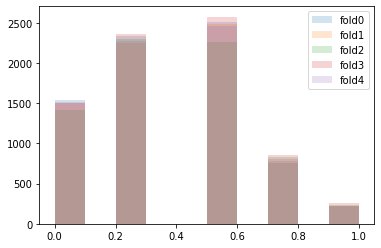

**********
fold-0
trainable parameters: 1842945
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5426161199544384, val_loss:0.535008888820122, val_score:0.8453897898453656

Epoch2　train_loss:0.5320700465050419, val_loss:0.5326110751464449, val_score:0.8467075080775358

Epoch3　train_loss:0.5319480819512258, val_loss:0.5329242934440744, val_score:0.8471636196635901

Epoch4　train_loss:0.5306058225378526, val_loss:0.5328370939041006, val_score:0.8472648026989467

Epoch5　train_loss:0.5310092861145999, val_loss:0.5322270557798189, val_score:0.8476747429039817

Epoch6　train_loss:0.5308496735792244, val_loss:0.5320602501260823, val_score:0.8474979303989275
    score did not impove from 0.8476747429039817 (now 1 consecutive)

Epoch 00007: reducing learning rate of group 0 to 5.0000e-04.
Epoch7　train_loss:0.530239871117921, val_loss:0.5323308295217054, val_score:0.8472524499318339
    score did not impove from 0.8476747429039817 (now 2 consecutive)

Epoch8　train_loss:0.5298686106648065, val_loss:0.5314557562614309, val_score:0.8483763412957473

Epoch9　train_loss:0.529644

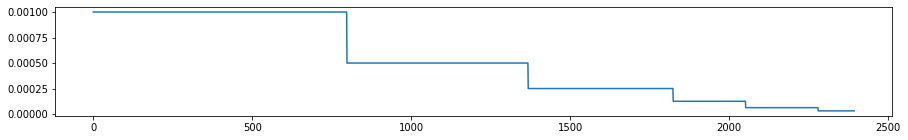


**********
fold-1
trainable parameters: 1842945
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5447694810858944, val_loss:0.528292271597632, val_score:0.8588248555998966

Epoch2　train_loss:0.5332079053970805, val_loss:0.5280330006418557, val_score:0.8592197901123447

Epoch3　train_loss:0.5314952127243343, val_loss:0.5274664872679217, val_score:0.8598030053280451

Epoch4　train_loss:0.5315316442334861, val_loss:0.5281750241230274, val_score:0.8593821915987118
    score did not impove from 0.8598030053280451 (now 1 consecutive)

Epoch 00005: reducing learning rate of group 0 to 5.0000e-04.
Epoch5　train_loss:0.5309790738841944, val_loss:0.5281608454112349, val_score:0.8588529766961585
    score did not impove from 0.8598030053280451 (now 2 consecutive)

Epoch6　train_loss:0.5308212462747306, val_loss:0.5297062407279837, val_score:0.8585459154993107
    score did not impove from 0.8598030053280451 (now 3 consecutive)

Epoch 00007: reducing learning rate of group 0 to 2.5000e-04.
Epoch7　train_loss:0.5308832866058015, val_loss:0.5280749335371214, val_score:0.858920083

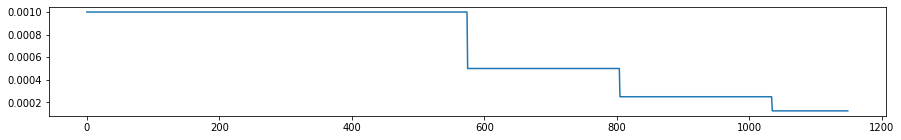


**********
fold-2
trainable parameters: 1842945
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5449519907696205, val_loss:0.5287191601736205, val_score:0.8600394577143177

Epoch2　train_loss:0.5328076173338974, val_loss:0.5277880877256393, val_score:0.859990374173018
    score did not impove from 0.8600394577143177 (now 1 consecutive)

Epoch3　train_loss:0.5321698050227082, val_loss:0.5280151452336993, val_score:0.8607708521764397

Epoch4　train_loss:0.5319481996590631, val_loss:0.527833165866988, val_score:0.8600034967560063
    score did not impove from 0.8607708521764397 (now 1 consecutive)

Epoch 00005: reducing learning rate of group 0 to 5.0000e-04.
Epoch5　train_loss:0.5320882308378554, val_loss:0.5272874480911663, val_score:0.8606580939882414
    score did not impove from 0.8607708521764397 (now 2 consecutive)

Epoch6　train_loss:0.5309812303697854, val_loss:0.527398903455053, val_score:0.8610270722390053

Epoch7　train_loss:0.53068937335098, val_loss:0.527087613940239, val_score:0.8614117092155934

Epoch8　train_loss:0.5310587085652769, val_loss:0.527119417

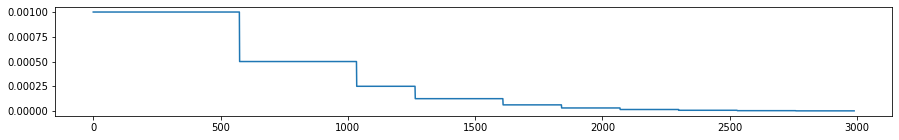


**********
fold-3
trainable parameters: 1842945
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5422690641134977, val_loss:0.5325558692216873, val_score:0.8554636971664353

Epoch2　train_loss:0.5324433126619884, val_loss:0.5327938586473465, val_score:0.8556638009413067

Epoch3　train_loss:0.531578513394509, val_loss:0.5338642746210098, val_score:0.8551417867223404
    score did not impove from 0.8556638009413067 (now 1 consecutive)

Epoch 00004: reducing learning rate of group 0 to 5.0000e-04.
Epoch4　train_loss:0.5308460377688918, val_loss:0.5320709506670634, val_score:0.8556697898946517

Epoch5　train_loss:0.530207849506821, val_loss:0.5318462779124578, val_score:0.8563615824339423

Epoch6　train_loss:0.5297144103263106, val_loss:0.5322337319453557, val_score:0.8552500833360138
    score did not impove from 0.8563615824339423 (now 1 consecutive)

Epoch 00007: reducing learning rate of group 0 to 2.5000e-04.
Epoch7　train_loss:0.5299817600420543, val_loss:0.5315455436706543, val_score:0.8559800264967578
    score did not impove from 0.8563615824339423 (now 2 consec

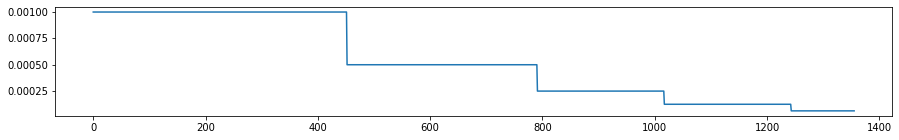


**********
fold-4
trainable parameters: 1842945
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5432815201449812, val_loss:0.5336513169880571, val_score:0.844351204036881

Epoch2　train_loss:0.531278987202728, val_loss:0.5334491174796532, val_score:0.8441680894309961
    score did not impove from 0.844351204036881 (now 1 consecutive)

Epoch3　train_loss:0.5305325660789222, val_loss:0.5332928803460352, val_score:0.844538185224861

Epoch4　train_loss:0.5304410162202099, val_loss:0.532881949482293, val_score:0.8452409309538379

Epoch5　train_loss:0.5306382291672522, val_loss:0.5329277474304726, val_score:0.8451040452165887
    score did not impove from 0.8452409309538379 (now 1 consecutive)

Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.
Epoch6　train_loss:0.5304353469819353, val_loss:0.5334264995722935, val_score:0.8446082914075531
    score did not impove from 0.8452409309538379 (now 2 consecutive)

Epoch7　train_loss:0.529864459445602, val_loss:0.5336058067864385, val_score:0.8447068592521872
    score did not impove from 0.8452409309538379 (now 3 con

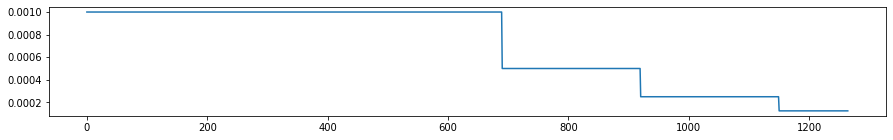


CV Score: 0.8541697598769665
--------------------
nn-1


,id,anchor,target,context,score,preds_0,preds_1,preds_2,preds_3,preds_4,preds_5,fold
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,0.466284,0.510132,0.317783,0.416120,0.462182,0.146545,2
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,0.722547,0.575757,0.713420,0.545296,0.637189,0.604272,2
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,0.117356,0.258999,0.243357,0.281782,0.258671,0.226358,2
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,0.549443,0.625390,0.510812,0.510402,0.562911,0.526696,2
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,0.021158,0.013692,0.044547,0.083340,0.087163,0.071804,2


fold
0    6890
1    7340
2    7348
3    7310
4    7585
dtype: int64

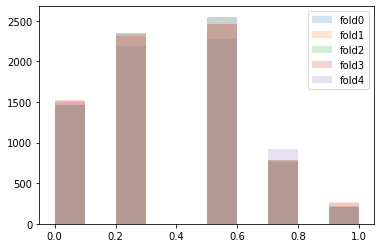

**********
fold-0
trainable parameters: 1842945
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5432983914147252, val_loss:0.5291437120349319, val_score:0.8496277131197825

Epoch2　train_loss:0.5326101282368536, val_loss:0.5294079184532166, val_score:0.850325704261342

Epoch3　train_loss:0.5325790752535281, val_loss:0.5281238721476661, val_score:0.8510561541380323

Epoch4　train_loss:0.5318674854610277, val_loss:0.5305121055355778, val_score:0.84941079146212
    score did not impove from 0.8510561541380323 (now 1 consecutive)

Epoch5　train_loss:0.5317999464014302, val_loss:0.5279332818808379, val_score:0.8515655867686489

Epoch6　train_loss:0.5314421677071115, val_loss:0.5280018658549698, val_score:0.8517113699984136

Epoch7　train_loss:0.5312242246192435, val_loss:0.5284795617615735, val_score:0.8512092121941391
    score did not impove from 0.8517113699984136 (now 1 consecutive)

Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.
Epoch8　train_loss:0.5315411914949831, val_loss:0.5285690824190775, val_score:0.851794072026243

Epoch9　train_loss:0.53042941

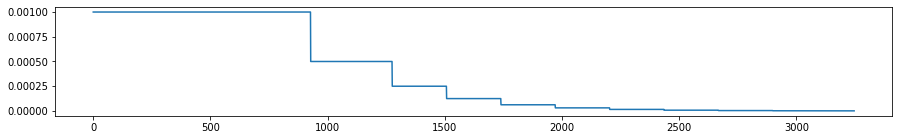


**********
fold-1
trainable parameters: 1842945
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5443318655005599, val_loss:0.5287256877997826, val_score:0.8524753113050967

Epoch2　train_loss:0.5324117211641464, val_loss:0.5277103771423471, val_score:0.8522450232358291
    score did not impove from 0.8524753113050967 (now 1 consecutive)

Epoch3　train_loss:0.5322578438615377, val_loss:0.5283813764309061, val_score:0.8526493061321356

Epoch4　train_loss:0.5317046621204478, val_loss:0.5280364690155819, val_score:0.8524004233179421
    score did not impove from 0.8526493061321356 (now 1 consecutive)

Epoch5　train_loss:0.5313460447091972, val_loss:0.5272467639939539, val_score:0.8528051850249445

Epoch6　train_loss:0.5316768354546707, val_loss:0.5270185789157604, val_score:0.8529439516381996

Epoch7　train_loss:0.5314331326336987, val_loss:0.5284564433426693, val_score:0.8518945549223056
    score did not impove from 0.8529439516381996 (now 1 consecutive)

Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.
Epoch8　train_loss:0.5310789576146455, val_loss:0.527

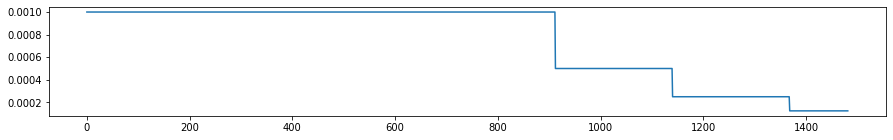


**********
fold-2
trainable parameters: 1842945
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5409732711526145, val_loss:0.5418252636646402, val_score:0.8414081636963394

Epoch2　train_loss:0.5315044999650095, val_loss:0.5418184820947975, val_score:0.8420545948775514

Epoch3　train_loss:0.5296759341670348, val_loss:0.5400531929114769, val_score:0.8420406756146908
    score did not impove from 0.8420545948775514 (now 1 consecutive)

Epoch 00004: reducing learning rate of group 0 to 5.0000e-04.
Epoch4　train_loss:0.529128716846483, val_loss:0.5395632602017502, val_score:0.8417603645957209
    score did not impove from 0.8420545948775514 (now 2 consecutive)

Epoch5　train_loss:0.5280655880944919, val_loss:0.5387227072797972, val_score:0.8428078859085462

Epoch6　train_loss:0.528233871523258, val_loss:0.539131063839485, val_score:0.8423591171082813
    score did not impove from 0.8428078859085462 (now 1 consecutive)

Epoch 00007: reducing learning rate of group 0 to 2.5000e-04.
Epoch7　train_loss:0.5277557652608483, val_loss:0.5397234898189018, val_score:0.84177115325

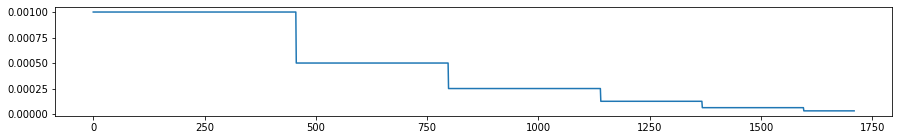


**********
fold-3
trainable parameters: 1842945
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Exception in thread Thread-1248:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/_utils/pin_memory.py", line 28, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 295, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/pyt

KeyboardInterrupt: ignored

In [25]:
df_oof = df.copy()

for i in range(5):

    print('--'*10)
    print(f'nn-{i}')

    CFG.seed += 1

    path = os.path.join(CFG.OUTPUT_DIR, f'STACKING_seed{CFG.seed}_MODEL/')

    if not os.path.exists(path):
        os.makedirs(path)

    df = create_folds(df, CFG.num_fold, CFG.seed)
    display(df.head())
    display(df.groupby('fold').size())

    fig, ax = plt.subplots()
    for i in range(CFG.num_fold):
      ax.hist(df.loc[df['fold']==i, 'score'], alpha=0.2, label=f'fold{i}')
    ax.legend()
    plt.show()

    for fold in range(CFG.num_fold):

        print('*'*10)
        print(f'fold-{fold}')

        train = df[df['fold']!=fold]
        valid = df[df['fold']==fold]
        
        oof = np.zeros(len(train))
        test_preds_lst = []

        train_dset = StackingDataset_1Dcnn(train, feat_cols_cnn[i])
        valid_dset = StackingDataset_1Dcnn(valid, feat_cols_cnn[i])

        train_loader = DataLoader(train_dset, batch_size=CFG.BATCH_SIZE, pin_memory=True, shuffle=True, drop_last=True, num_workers=os.cpu_count())
        valid_loader = DataLoader(valid_dset, batch_size=CFG.BATCH_SIZE, pin_memory=True, shuffle=False, drop_last=False, num_workers=os.cpu_count())

        model = StackingModel_1Dcnn(CFG)
        model.to(CFG.DEVICE)

        model_path = os.path.join(path, f'base_fold{fold}.bin')

        trainable_num = 0
        untrainable_num = 0
        for p in model.parameters():
            if p.requires_grad:
                trainable_num += p.numel()
            else:
                untrainable_num += p.numel()
                
        print(f'trainable parameters: {trainable_num}')
        print(f'untrainable parameters: {untrainable_num}')
        
        optimizer = torch.optim.AdamW(model.parameters())
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, verbose=True)
                    
        valid_best_score = float('-999')
        counter = 0

        lr_list = []

        for epoch in tqdm(range(CFG.N_EPOCHS)):
            train_loss, lrs = train_loop(model, optimizer, scheduler, train_loader)
            valid_loss, valid_predict = valid_loop(model, valid_loader)

            valid['oof'] = valid_predict

            val_score = np.corrcoef(valid['oof'], valid[target_col])[0][1]

            scheduler.step(val_score)

            print(f'Epoch{epoch+1}　train_loss:{train_loss}, val_loss:{valid_loss}, val_score:{val_score}')

            if val_score > valid_best_score:
                valid_best_score = val_score
                counter = 0
                torch.save(model.state_dict(), model_path)

            else:
                counter += 1
                print(f'    score did not impove from {valid_best_score} (now {counter} consecutive)')

            # plt.figure(figsize=(15, 2))
            # plt.plot(lrs)
            # plt.show()

            lr_list.append(np.mean(lrs))
            lr_list.extend(lrs)

            print('')

            torch.cuda.empty_cache()
            gc.collect()

            if counter > 6:
              print(f'Fold{fold} Epoch{epoch+1} Early Stopping')
              print(f'best_score: {valid_best_score}')
              print('')
              break
        
        print(f'Fold{fold} best_score: {valid_best_score}')

        plt.figure(figsize=(15, 2))
        plt.plot(lr_list)
        plt.show()
        print('')

        model.load_state_dict(torch.load(model_path))
        df_oof.loc[df['fold']==fold, f'oof'] = test_loop(model, valid_loader)

    score = np.corrcoef(df_oof['oof'], df_oof[target_col])[0][1]
    df_oof.to_pickle('1dcnn.pkl')
    print(f'CV Score: {score}')

# 4. 2dcnn

In [ ]:
class StackingDataset_2Dcnn(Dataset):
    def __init__(self, df, feat_cols):
        self.df = df
        self.feats = df[feat_cols].values.reshape(-1, len(stacking_list), 1, 1)
        self.target = df[target_col].values
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        feats = torch.tensor(self.feats[idx]).float()
        target = torch.tensor(self.target[idx]).float()

        d = {
            "feats": feats,
            "target" : target,
        }

        return d

In [ ]:
class StackingModel_2Dcnn(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg


        self.cnn1 = nn.Conv2d(len(stacking_list), 256, kernel_size=(1, 3), padding=1)
        self.cnn2 = nn.Conv2d(256, 1024, kernel_size=(1, 3), padding=1)

        self.linear0 = nn.Linear(5120, 1024)
        self.dropout0 = nn.Dropout(0.2)
        self.linear1 = nn.Linear(1024, 1)
        
    def forward(self, feats, y=None):
        x = self.cnn1(feats)
        x = torch.relu(x)
        x = self.cnn2(x)
        x = torch.relu(x)

        x = torch.nn.Flatten()(x)

        x = self.linear0(x)
        x = torch.relu(x)
        x = self.dropout0(x)
        output = self.linear1(x)

        if y is None:
            loss = None
        else:
            loss = self.loss_fn(output, y)
            # loss = 0 - torch.corrcoef(torch.stack((output.reshape(-1), y.reshape(-1))))[0][1]

        return output, loss


    def loss_fn(self, y_pred, y_true):
        criterion = nn.BCEWithLogitsLoss()
        loss = criterion(y_pred.reshape(-1), y_true.reshape(-1))

        return loss

In [ ]:
def train_loop(model, optimizer, scheduler, loader):
    losses, lrs = [], []
    model.train()
    for d in loader:
        out, loss = model(d['feats'].to(CFG.DEVICE), d['target'].to(CFG.DEVICE))
        
        losses.append(loss.item())
        step_lrs = np.array([param_group["lr"] for param_group in optimizer.param_groups])
        lrs.extend(step_lrs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # scheduler.step()

    return np.array(losses).mean(), lrs


def valid_loop(model, loader):
    losses, predicts = [], []
    model.eval()
    for d in loader:
        with torch.no_grad():
            out, loss = model(d['feats'].to(CFG.DEVICE), d['target'].to(CFG.DEVICE))
        pred = torch.tensor(out.sigmoid())
        losses.append(loss.item())
        predicts.append(pred.cpu())

    return np.array(losses).mean(), torch.vstack(predicts).numpy().reshape(-1)

def test_loop(model, loader):
    predicts = []
    model.eval()
    for d in loader:
        with torch.no_grad():
            out, _ = model(d['feats'].to(CFG.DEVICE))
        pred = torch.tensor(out.sigmoid())
        predicts.append(pred.cpu())

    return torch.vstack(predicts).numpy().reshape(-1)

--------------------
nn-0


,id,anchor,target,context,score,preds_0,preds_1,preds_2,preds_3,preds_4,preds_5,fold
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,0.466284,0.510132,0.317783,0.416120,0.462182,0.146545,3
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,0.722547,0.575757,0.713420,0.545296,0.637189,0.604272,3
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,0.117356,0.258999,0.243357,0.281782,0.258671,0.226358,3
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,0.549443,0.625390,0.510812,0.510402,0.562911,0.526696,3
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,0.021158,0.013692,0.044547,0.083340,0.087163,0.071804,3


fold
0    7587
1    6861
2    7295
3    7966
4    6764
dtype: int64

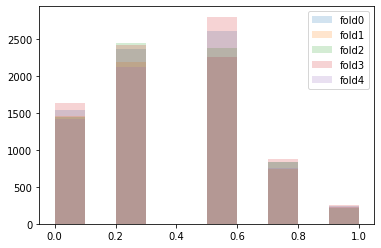

**********
fold-0
trainable parameters: 6037249
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5450339777661222, val_loss:0.535775093237559, val_score:0.8541882181384309

Epoch2　train_loss:0.5327720519687448, val_loss:0.5333038916190466, val_score:0.8540575423869841
    score did not impove from 0.8541882181384309 (now 1 consecutive)

Epoch3　train_loss:0.5312457116586822, val_loss:0.5321410775184632, val_score:0.8545693534020151

Epoch4　train_loss:0.5313005061554057, val_loss:0.5324285676081976, val_score:0.8547064922839561

Epoch5　train_loss:0.5306165936802115, val_loss:0.5330730934937795, val_score:0.8539629165637742
    score did not impove from 0.8547064922839561 (now 1 consecutive)

Epoch6　train_loss:0.5307034932609115, val_loss:0.531830816467603, val_score:0.8550938411478398

Epoch7　train_loss:0.5304818799985307, val_loss:0.5320740868647893, val_score:0.8551025770066468

Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.
Epoch8　train_loss:0.5306343832718474, val_loss:0.5319084336360296, val_score:0.8548688236870111
    score did not impove fr

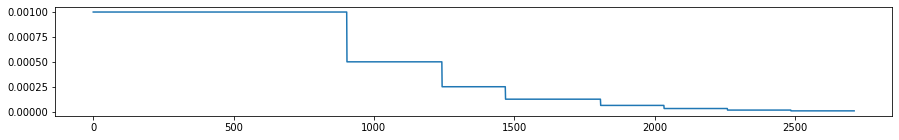


**********
fold-1
trainable parameters: 6037249
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5455402332803477, val_loss:0.5273876598587742, val_score:0.8517595772640517

Epoch2　train_loss:0.5341706708721493, val_loss:0.5279340821283834, val_score:0.8516779847915708
    score did not impove from 0.8517595772640517 (now 1 consecutive)

Epoch 00003: reducing learning rate of group 0 to 5.0000e-04.
Epoch3　train_loss:0.5339329162369604, val_loss:0.5269188505631907, val_score:0.8518040586749641

Epoch4　train_loss:0.5321519030177075, val_loss:0.5287052006633194, val_score:0.8512265211212181
    score did not impove from 0.8518040586749641 (now 1 consecutive)

Epoch 00005: reducing learning rate of group 0 to 2.5000e-04.
Epoch5　train_loss:0.5326792043188344, val_loss:0.5269227359029982, val_score:0.8518241843355888

Epoch6　train_loss:0.5314759969711303, val_loss:0.5264645274038668, val_score:0.852125189765775

Epoch7　train_loss:0.5316421267778977, val_loss:0.5263665969725009, val_score:0.8522475292736186

Epoch8　train_loss:0.5312875195689823, val_loss:0.52731238691

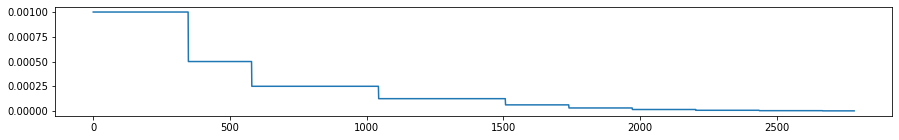


**********
fold-2
trainable parameters: 6037249
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5437981299066965, val_loss:0.5329968590160896, val_score:0.8565097119328219

Epoch2　train_loss:0.5329765247560181, val_loss:0.5329241146301401, val_score:0.8565413434694822

Epoch3　train_loss:0.5313875092341837, val_loss:0.5325609815531763, val_score:0.8567161345081044

Epoch4　train_loss:0.5309789225590967, val_loss:0.5315017587152021, val_score:0.8579405290271097

Epoch5　train_loss:0.5309521558537947, val_loss:0.5336048746931141, val_score:0.85706085181874
    score did not impove from 0.8579405290271097 (now 1 consecutive)

Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.
Epoch6　train_loss:0.530325107342374, val_loss:0.5315434316108967, val_score:0.8579807846075634

Epoch7　train_loss:0.5298494213977746, val_loss:0.5317795513005092, val_score:0.857957279925407
    score did not impove from 0.8579807846075634 (now 1 consecutive)

Epoch 00008: reducing learning rate of group 0 to 2.5000e-04.
Epoch8　train_loss:0.5297231953755944, val_loss:0.53176726452235

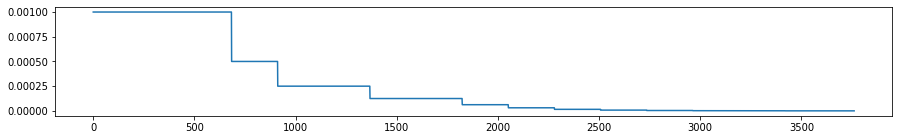


**********
fold-3
trainable parameters: 6037249
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5430206836343886, val_loss:0.5320435790345073, val_score:0.8508492722548573

Epoch2　train_loss:0.5329251120219359, val_loss:0.5337544288486242, val_score:0.8507519890687106
    score did not impove from 0.8508492722548573 (now 1 consecutive)

Epoch3　train_loss:0.5314531804205062, val_loss:0.5327409720048308, val_score:0.8525476601640508

Epoch4　train_loss:0.5317813423839776, val_loss:0.5375137832015753, val_score:0.8502404263358045
    score did not impove from 0.8525476601640508 (now 1 consecutive)

Epoch 00005: reducing learning rate of group 0 to 5.0000e-04.
Epoch5　train_loss:0.5308227633033786, val_loss:0.5315488129854202, val_score:0.8522204091309474
    score did not impove from 0.8525476601640508 (now 2 consecutive)

Epoch6　train_loss:0.5297392773198651, val_loss:0.5308909108862281, val_score:0.8523114673100329
    score did not impove from 0.8525476601640508 (now 3 consecutive)

Epoch7　train_loss:0.5301384549957138, val_loss:0.5303833018988371, val_score:0.8

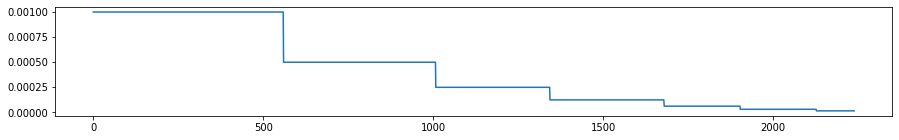


**********
fold-4
trainable parameters: 6037249
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5454671778555574, val_loss:0.532198076998746, val_score:0.8486893684556379

Epoch2　train_loss:0.5333314098674675, val_loss:0.5328365542270519, val_score:0.8493301083955783

Epoch3　train_loss:0.5319851205266756, val_loss:0.5307126221833406, val_score:0.8500307409757807

Epoch4　train_loss:0.5316757510962158, val_loss:0.5292914730531199, val_score:0.8511521497009382

Epoch5　train_loss:0.5315831020988268, val_loss:0.5307209259933896, val_score:0.850668340196939
    score did not impove from 0.8511521497009382 (now 1 consecutive)

Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.
Epoch6　train_loss:0.5312748872514429, val_loss:0.530350579155816, val_score:0.8486946808557666
    score did not impove from 0.8511521497009382 (now 2 consecutive)

Epoch7　train_loss:0.5305075496435165, val_loss:0.5297866827911801, val_score:0.8507663680555787
    score did not impove from 0.8511521497009382 (now 3 consecutive)

Epoch 00008: reducing learning rate of group 0 to 2.500

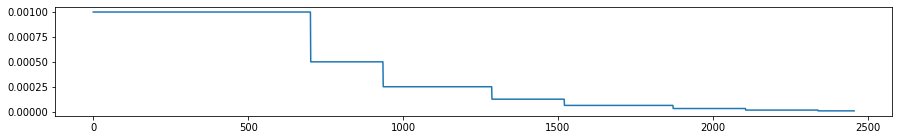


CV Score: 0.8543530937996844
--------------------
nn-1


,id,anchor,target,context,score,preds_0,preds_1,preds_2,preds_3,preds_4,preds_5,fold
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,0.466284,0.510132,0.317783,0.416120,0.462182,0.146545,4
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,0.722547,0.575757,0.713420,0.545296,0.637189,0.604272,4
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,0.117356,0.258999,0.243357,0.281782,0.258671,0.226358,4
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,0.549443,0.625390,0.510812,0.510402,0.562911,0.526696,4
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,0.021158,0.013692,0.044547,0.083340,0.087163,0.071804,4


fold
0    7273
1    7528
2    7534
3    7319
4    6819
dtype: int64

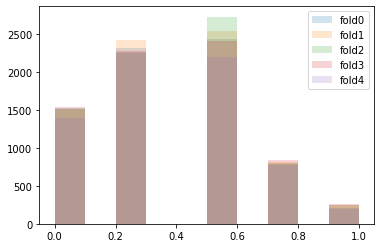

**********
fold-0
trainable parameters: 6037249
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5434638063112894, val_loss:0.5382478566005312, val_score:0.8432963675862758

Epoch2　train_loss:0.5328321914400971, val_loss:0.5320335996562037, val_score:0.8453817057415117

Epoch3　train_loss:0.5326129464726699, val_loss:0.5327207466651653, val_score:0.845370196552163
    score did not impove from 0.8453817057415117 (now 1 consecutive)

Epoch4　train_loss:0.5316409612433952, val_loss:0.531310591204413, val_score:0.8464927058946188

Epoch5　train_loss:0.5311549413099623, val_loss:0.5315570522998941, val_score:0.8457488162529228
    score did not impove from 0.8464927058946188 (now 1 consecutive)

Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.
Epoch6　train_loss:0.5311178988532016, val_loss:0.532522667070915, val_score:0.8456979515911245
    score did not impove from 0.8464927058946188 (now 2 consecutive)

Epoch7　train_loss:0.530112657107805, val_loss:0.531762406743806, val_score:0.8462768503873245
    score did not impove from 0.8464927058946188 (now 3 co

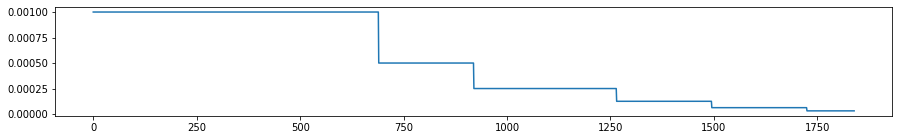


**********
fold-1
trainable parameters: 6037249
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5430378866406669, val_loss:0.5328685700893402, val_score:0.852805878585494

Epoch2　train_loss:0.5317824941820803, val_loss:0.5346395780642827, val_score:0.8512794228127797
    score did not impove from 0.852805878585494 (now 1 consecutive)

Epoch 00003: reducing learning rate of group 0 to 5.0000e-04.
Epoch3　train_loss:0.531501853360539, val_loss:0.5341437419255575, val_score:0.8515832662709859
    score did not impove from 0.852805878585494 (now 2 consecutive)

Epoch4　train_loss:0.5303944056540464, val_loss:0.5322064032157262, val_score:0.8537741518421208

Epoch5　train_loss:0.5303575214558998, val_loss:0.5339245557785034, val_score:0.8527401580973797
    score did not impove from 0.8537741518421208 (now 1 consecutive)

Epoch 00006: reducing learning rate of group 0 to 2.5000e-04.
Epoch6　train_loss:0.5301445390270875, val_loss:0.5319658845663071, val_score:0.8533553615135608
    score did not impove from 0.8537741518421208 (now 2 consecutive)

Epoch7　train_loss:0.52

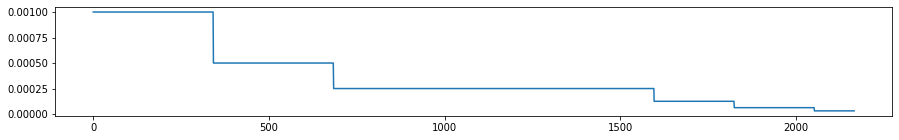


**********
fold-2
trainable parameters: 6037249
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5437342015515386, val_loss:0.535619173447291, val_score:0.8547385314717036

Epoch2　train_loss:0.5316154110220681, val_loss:0.5352124909559886, val_score:0.8552202316128439

Epoch3　train_loss:0.5308689712423139, val_loss:0.5354683458805084, val_score:0.8565413553862067

Epoch4　train_loss:0.5306545490712191, val_loss:0.5353846460580826, val_score:0.8556839568336863
    score did not impove from 0.8565413553862067 (now 1 consecutive)

Epoch5　train_loss:0.5301837517624408, val_loss:0.534922061363856, val_score:0.8567483229907934

Epoch6　train_loss:0.5302910810023282, val_loss:0.5346104224522908, val_score:0.8558282423809364
    score did not impove from 0.8567483229907934 (now 1 consecutive)

Epoch7　train_loss:0.5303291939528643, val_loss:0.5343440473079681, val_score:0.857426100241164

Epoch8　train_loss:0.5296854353056545, val_loss:0.5353986710309983, val_score:0.8572183534972848
    score did not impove from 0.857426100241164 (now 1 consecutive)

Epoch 00009: reducing

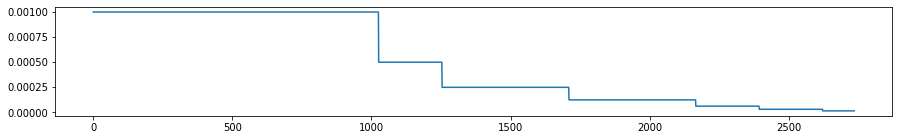


**********
fold-3
trainable parameters: 6037249
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5457199147317262, val_loss:0.5282036805975026, val_score:0.8537832939671159

Epoch2　train_loss:0.5341296662799025, val_loss:0.5302756387611915, val_score:0.8546390178516795

Epoch3　train_loss:0.5339586054329324, val_loss:0.527373251216165, val_score:0.8557244026682223

Epoch4　train_loss:0.5324262375325228, val_loss:0.5265969705992731, val_score:0.8556372868633234
    score did not impove from 0.8557244026682223 (now 1 consecutive)

Epoch 00005: reducing learning rate of group 0 to 5.0000e-04.
Epoch5　train_loss:0.5325526560829804, val_loss:0.5276258598113882, val_score:0.8552577497298363
    score did not impove from 0.8557244026682223 (now 2 consecutive)

Epoch6　train_loss:0.5320449896090853, val_loss:0.5259639518014316, val_score:0.8557487610708114

Epoch 00007: reducing learning rate of group 0 to 2.5000e-04.
Epoch7　train_loss:0.5318480682584037, val_loss:0.5266707210705198, val_score:0.8556046667702057
    score did not impove from 0.8557487610708114 (now 1 conse

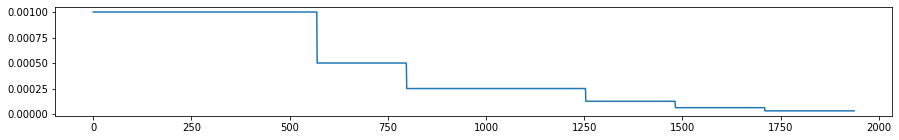


**********
fold-4
trainable parameters: 6037249
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5451617059500321, val_loss:0.5306586733570805, val_score:0.8549040474842875

Epoch2　train_loss:0.5332685123319211, val_loss:0.5301103680222122, val_score:0.8546074481648485
    score did not impove from 0.8549040474842875 (now 1 consecutive)

Epoch3　train_loss:0.5325916932976764, val_loss:0.5286747592466848, val_score:0.8558971059199265

Epoch4　train_loss:0.5321075475734213, val_loss:0.5301404065555997, val_score:0.8547737109678104
    score did not impove from 0.8558971059199265 (now 1 consecutive)

Epoch 00005: reducing learning rate of group 0 to 5.0000e-04.
Epoch5　train_loss:0.5316751449004463, val_loss:0.5303326624411123, val_score:0.855932040224149

Epoch6　train_loss:0.53045182072598, val_loss:0.5288635691006979, val_score:0.8559728274580418

Epoch7　train_loss:0.5311072100763735, val_loss:0.528448345484557, val_score:0.8562714394281474

Epoch8　train_loss:0.5308061902937682, val_loss:0.5284861094421811, val_score:0.8565944786014796

Epoch9　train_loss:0.53101041

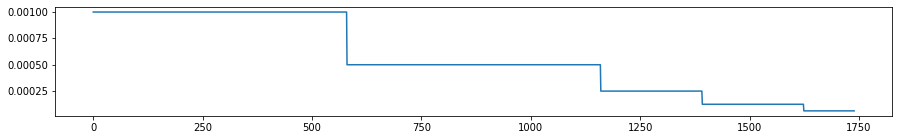


CV Score: 0.8542019183116937
--------------------
nn-2


,id,anchor,target,context,score,preds_0,preds_1,preds_2,preds_3,preds_4,preds_5,fold
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,0.466284,0.510132,0.317783,0.416120,0.462182,0.146545,2
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,0.722547,0.575757,0.713420,0.545296,0.637189,0.604272,2
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,0.117356,0.258999,0.243357,0.281782,0.258671,0.226358,2
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,0.549443,0.625390,0.510812,0.510402,0.562911,0.526696,2
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,0.021158,0.013692,0.044547,0.083340,0.087163,0.071804,2


fold
0    7642
1    7082
2    7004
3    7552
4    7193
dtype: int64

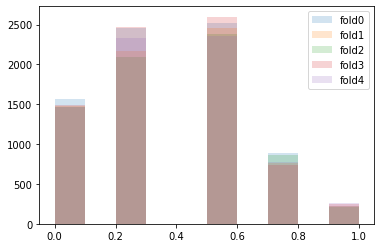

**********
fold-0
trainable parameters: 6037249
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5443862397223711, val_loss:0.5373990515867869, val_score:0.8443471945658384

Epoch2　train_loss:0.5327535130615745, val_loss:0.5351196964581807, val_score:0.8455435863777812

Epoch3　train_loss:0.5316981542855501, val_loss:0.5368989169597626, val_score:0.8447451841696996
    score did not impove from 0.8455435863777812 (now 1 consecutive)

Epoch4　train_loss:0.5322607678494283, val_loss:0.5349802076816559, val_score:0.845684347541101

Epoch5　train_loss:0.5305905991366932, val_loss:0.5336895247300466, val_score:0.8467247037537657

Epoch6　train_loss:0.5306386450039489, val_loss:0.5333235720793407, val_score:0.8470424403497973

Epoch7　train_loss:0.5305502864399126, val_loss:0.5336040079593658, val_score:0.8471450212527551

Epoch8　train_loss:0.5302978493273258, val_loss:0.53282271027565, val_score:0.8472826460180181

Epoch9　train_loss:0.5298224394874913, val_loss:0.5331863423188528, val_score:0.8468451938331225
    score did not impove from 0.8472826460180181 (now 1 consec

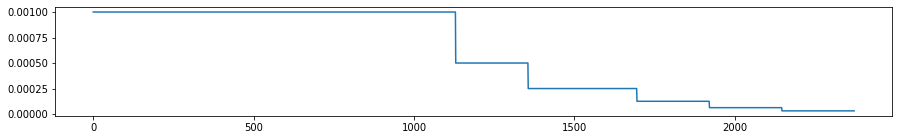


**********
fold-1
trainable parameters: 6037249
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.544754399280799, val_loss:0.531162657908031, val_score:0.8571676469894851

Epoch2　train_loss:0.5335005357077247, val_loss:0.5305571470941816, val_score:0.8571738806411495

Epoch3　train_loss:0.532924596154899, val_loss:0.5308454568896975, val_score:0.8573455065748835

Epoch4　train_loss:0.5321188733765954, val_loss:0.5331734269857407, val_score:0.8560904171213667
    score did not impove from 0.8573455065748835 (now 1 consecutive)

Epoch5　train_loss:0.5315643883588022, val_loss:0.5299704745411873, val_score:0.8583019494860847

Epoch6　train_loss:0.5314218362695292, val_loss:0.531502229826791, val_score:0.8544207316956306
    score did not impove from 0.8583019494860847 (now 1 consecutive)

Epoch 00007: reducing learning rate of group 0 to 5.0000e-04.
Epoch7　train_loss:0.531594177348572, val_loss:0.5307778950248446, val_score:0.8580200714117039
    score did not impove from 0.8583019494860847 (now 2 consecutive)

Epoch8　train_loss:0.530413138761855, val_loss:0.529693873

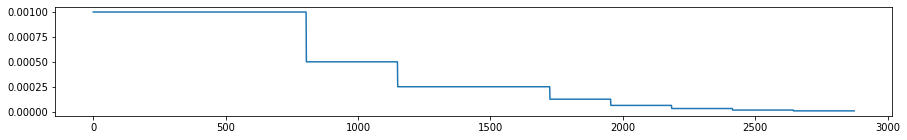


**********
fold-2
trainable parameters: 6037249
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5442265606444815, val_loss:0.5327868312597275, val_score:0.8496261175220531

Epoch2　train_loss:0.5331008180328037, val_loss:0.5314415267535618, val_score:0.8507598400860672

Epoch3　train_loss:0.5324442464372386, val_loss:0.5300437829324177, val_score:0.8516848834485512

Epoch4　train_loss:0.5317467464053113, val_loss:0.5297353938221931, val_score:0.8523038300359103

Epoch5　train_loss:0.5314431799494702, val_loss:0.5319206927503858, val_score:0.8498579357869696
    score did not impove from 0.8523038300359103 (now 1 consecutive)

Epoch6　train_loss:0.5311487993468409, val_loss:0.529038593173027, val_score:0.8531140662639634

Epoch7　train_loss:0.5309497864350029, val_loss:0.5289441794157028, val_score:0.853155243224928

Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.
Epoch8　train_loss:0.5315570310406063, val_loss:0.5310748411076409, val_score:0.8523748993110588
    score did not impove from 0.853155243224928 (now 1 consecutive)

Epoch9　train_loss:0.5300955

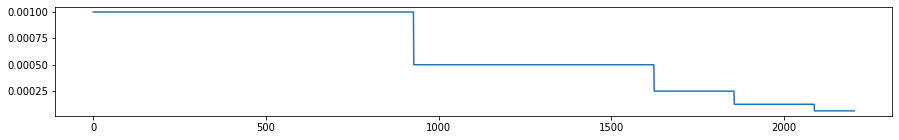


**********
fold-3
trainable parameters: 6037249
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5421823651662895, val_loss:0.5368310401837031, val_score:0.849860871310689

Epoch2　train_loss:0.5322942177632025, val_loss:0.5341609358787537, val_score:0.8511999843969227

Epoch3　train_loss:0.531614510874663, val_loss:0.5347051779429118, val_score:0.8501072098617388
    score did not impove from 0.8511999843969227 (now 1 consecutive)

Epoch 00004: reducing learning rate of group 0 to 5.0000e-04.
Epoch4　train_loss:0.5307505559176207, val_loss:0.535110064347585, val_score:0.8507272507094579
    score did not impove from 0.8511999843969227 (now 2 consecutive)

Epoch5　train_loss:0.5303774819310222, val_loss:0.5324585398038229, val_score:0.8516885592202326

Epoch6　train_loss:0.5299932866224221, val_loss:0.5326108306646347, val_score:0.8516493564130441
    score did not impove from 0.8516885592202326 (now 1 consecutive)

Epoch 00007: reducing learning rate of group 0 to 2.5000e-04.
Epoch7　train_loss:0.5297568927385977, val_loss:0.5328889807065328, val_score:0.85162048498

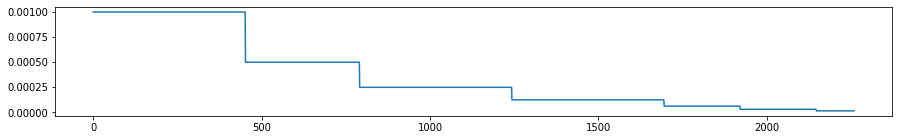


**********
fold-4
trainable parameters: 6037249
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.545755404129363, val_loss:0.5289976555725624, val_score:0.8579003581475366

Epoch2　train_loss:0.5333007236844615, val_loss:0.5284569099031645, val_score:0.857918997803687

Epoch3　train_loss:0.5336690142489317, val_loss:0.5269308542383129, val_score:0.8592142401631556

Epoch4　train_loss:0.5323043350587812, val_loss:0.5266227681061317, val_score:0.8596139796374843

Epoch5　train_loss:0.5319468514961109, val_loss:0.5266197837632278, val_score:0.8591812897157178
    score did not impove from 0.8596139796374843 (now 1 consecutive)

Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.
Epoch6　train_loss:0.53185336762353, val_loss:0.5273522621598737, val_score:0.8581590987952421
    score did not impove from 0.8596139796374843 (now 2 consecutive)

Epoch7　train_loss:0.5316172762398135, val_loss:0.5271936264531366, val_score:0.8585452024954283
    score did not impove from 0.8596139796374843 (now 3 consecutive)

Epoch 00008: reducing learning rate of group 0 to 2.5000

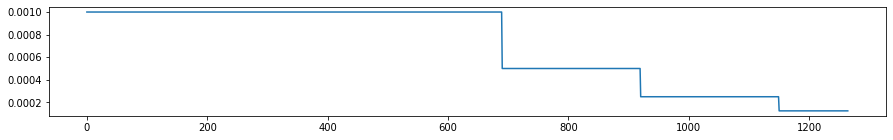


CV Score: 0.8540430999110785
--------------------
nn-3


,id,anchor,target,context,score,preds_0,preds_1,preds_2,preds_3,preds_4,preds_5,fold
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,0.466284,0.510132,0.317783,0.416120,0.462182,0.146545,1
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,0.722547,0.575757,0.713420,0.545296,0.637189,0.604272,1
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,0.117356,0.258999,0.243357,0.281782,0.258671,0.226358,1
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,0.549443,0.625390,0.510812,0.510402,0.562911,0.526696,1
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,0.021158,0.013692,0.044547,0.083340,0.087163,0.071804,1


fold
0    7081
1    7428
2    7622
3    6953
4    7389
dtype: int64

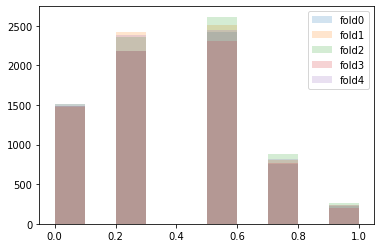

**********
fold-0
trainable parameters: 6037249
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5469233746591368, val_loss:0.5293375956160682, val_score:0.8588186956821339

Epoch2　train_loss:0.5334453616748777, val_loss:0.5326301785452026, val_score:0.8582272682452261
    score did not impove from 0.8588186956821339 (now 1 consecutive)

Epoch3　train_loss:0.5334920880564472, val_loss:0.5299669631889888, val_score:0.8597486752701392

Epoch4　train_loss:0.5324491604901197, val_loss:0.5283177644014359, val_score:0.8598535741842583

Epoch5　train_loss:0.5313440054132227, val_loss:0.5285948195627758, val_score:0.8591508203010046
    score did not impove from 0.8598535741842583 (now 1 consecutive)

Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.
Epoch6　train_loss:0.5318950916591444, val_loss:0.5294806318623679, val_score:0.8578139969758709
    score did not impove from 0.8598535741842583 (now 2 consecutive)

Epoch7　train_loss:0.530716823642714, val_loss:0.5288634066070829, val_score:0.8586797689856802
    score did not impove from 0.8598535741842583 (now 

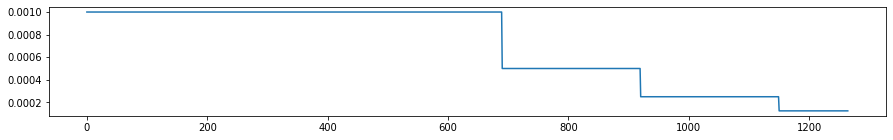


**********
fold-1
trainable parameters: 6037249
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.543813097002232, val_loss:0.5301330943902334, val_score:0.8558813322134992

Epoch2　train_loss:0.5324371372703958, val_loss:0.527173696955045, val_score:0.8585723098552556

Epoch3　train_loss:0.5329262848976439, val_loss:0.5259483993053437, val_score:0.8578429416575138
    score did not impove from 0.8585723098552556 (now 1 consecutive)

Epoch 00004: reducing learning rate of group 0 to 5.0000e-04.
Epoch4　train_loss:0.5310569988415305, val_loss:0.5277337918678919, val_score:0.8581356963462666
    score did not impove from 0.8585723098552556 (now 2 consecutive)

Epoch5　train_loss:0.5304948276123115, val_loss:0.5253417015075683, val_score:0.8593329078384976

Epoch6　train_loss:0.530509780466029, val_loss:0.52577549914519, val_score:0.8592371402596466
    score did not impove from 0.8593329078384976 (now 1 consecutive)

Epoch 00007: reducing learning rate of group 0 to 2.5000e-04.
Epoch7　train_loss:0.5305108884267048, val_loss:0.5258595764636993, val_score:0.8583742305798

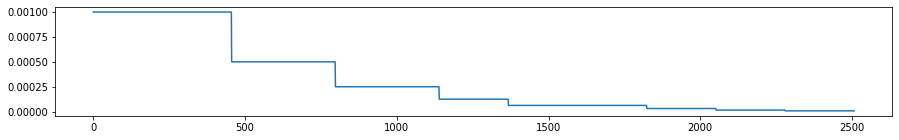


**********
fold-2
trainable parameters: 6037249
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5424931751830238, val_loss:0.5329714298248291, val_score:0.856710484295969

Epoch2　train_loss:0.5332626232079097, val_loss:0.5325397560993831, val_score:0.8564133973685956
    score did not impove from 0.856710484295969 (now 1 consecutive)

Epoch 00003: reducing learning rate of group 0 to 5.0000e-04.
Epoch3　train_loss:0.5323887360947472, val_loss:0.5353119810422261, val_score:0.8565594897119793
    score did not impove from 0.856710484295969 (now 2 consecutive)

Epoch4　train_loss:0.531119929626584, val_loss:0.5319334417581558, val_score:0.8575436733264412

Epoch5　train_loss:0.5310225108904498, val_loss:0.5326237748066585, val_score:0.8571949097427936
    score did not impove from 0.8575436733264412 (now 1 consecutive)

Epoch 00006: reducing learning rate of group 0 to 2.5000e-04.
Epoch6　train_loss:0.5304887489016566, val_loss:0.5318593879540762, val_score:0.8574607616113603
    score did not impove from 0.8575436733264412 (now 2 consecutive)

Epoch7　train_loss:0.52

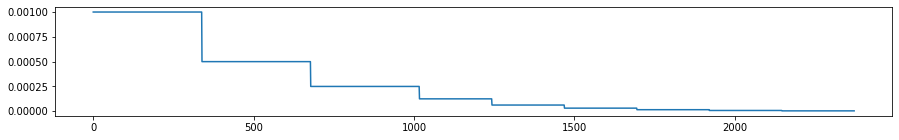


**********
fold-3
trainable parameters: 6037249
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5431070281111676, val_loss:0.5326551092522485, val_score:0.8429901225461345

Epoch2　train_loss:0.5329288863617441, val_loss:0.5297442121165139, val_score:0.8432836525431615

Epoch3　train_loss:0.5325291356314783, val_loss:0.5292255314333099, val_score:0.8431408775462914
    score did not impove from 0.8432836525431615 (now 1 consecutive)

Epoch 00004: reducing learning rate of group 0 to 5.0000e-04.
Epoch4　train_loss:0.5310668408870697, val_loss:0.5291920240436282, val_score:0.8425588365401807
    score did not impove from 0.8432836525431615 (now 2 consecutive)

Epoch5　train_loss:0.5310491784759189, val_loss:0.5286225963916097, val_score:0.8442325841714335

Epoch6　train_loss:0.5310053864251012, val_loss:0.5287553444504738, val_score:0.8439742400529034
    score did not impove from 0.8442325841714335 (now 1 consecutive)

Epoch7　train_loss:0.5306330452794614, val_loss:0.5286479890346527, val_score:0.8446687237863345

Epoch8　train_loss:0.53054976515148, val_loss:0.52902

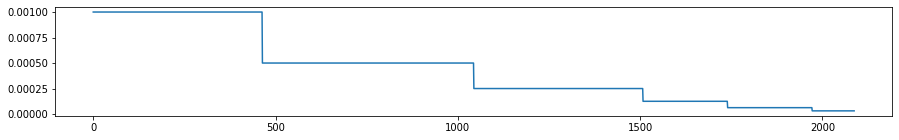


**********
fold-4
trainable parameters: 6037249
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5448716741747561, val_loss:0.5331438337934429, val_score:0.845674179955577

Epoch2　train_loss:0.5326325830105132, val_loss:0.5340775415815157, val_score:0.8455159691519556
    score did not impove from 0.845674179955577 (now 1 consecutive)

Epoch3　train_loss:0.5326092187809733, val_loss:0.5328490579950398, val_score:0.8469897149579944

Epoch4　train_loss:0.5320437903952809, val_loss:0.5332932410569027, val_score:0.8470472495653805

Epoch5　train_loss:0.5312405687517825, val_loss:0.5317017949860672, val_score:0.8475705053683155

Epoch6　train_loss:0.5306234692050292, val_loss:0.5312821906188439, val_score:0.8474501504072809
    score did not impove from 0.8475705053683155 (now 1 consecutive)

Epoch 00007: reducing learning rate of group 0 to 5.0000e-04.
Epoch7　train_loss:0.5308287998216342, val_loss:0.5335419321882313, val_score:0.8475167411560436
    score did not impove from 0.8475705053683155 (now 2 consecutive)

Epoch8　train_loss:0.5299363434314728, val_loss:0.53109

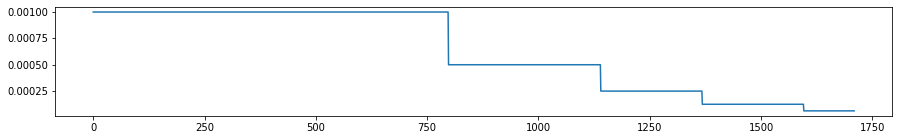


CV Score: 0.8541234212537624
--------------------
nn-4


,id,anchor,target,context,score,preds_0,preds_1,preds_2,preds_3,preds_4,preds_5,fold
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,0.466284,0.510132,0.317783,0.416120,0.462182,0.146545,3
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,0.722547,0.575757,0.713420,0.545296,0.637189,0.604272,3
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,0.117356,0.258999,0.243357,0.281782,0.258671,0.226358,3
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,0.549443,0.625390,0.510812,0.510402,0.562911,0.526696,3
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,0.021158,0.013692,0.044547,0.083340,0.087163,0.071804,3


fold
0    7386
1    7090
2    7390
3    7173
4    7434
dtype: int64

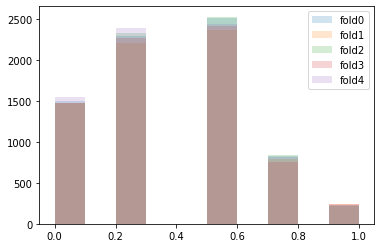

**********
fold-0
trainable parameters: 6037249
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5443064364711795, val_loss:0.5351321430041872, val_score:0.8507949296591831

Epoch2　train_loss:0.5314948316168996, val_loss:0.5341877711230311, val_score:0.850683731634513
    score did not impove from 0.8507949296591831 (now 1 consecutive)

Epoch 00003: reducing learning rate of group 0 to 5.0000e-04.
Epoch3　train_loss:0.5317416003847544, val_loss:0.5359435060928608, val_score:0.848674170766892
    score did not impove from 0.8507949296591831 (now 2 consecutive)

Epoch4　train_loss:0.5300022962346541, val_loss:0.5333612951739081, val_score:0.8522542692278726

Epoch5　train_loss:0.5301389288058324, val_loss:0.5337759975729317, val_score:0.851312363742029
    score did not impove from 0.8522542692278726 (now 1 consecutive)

Epoch 00006: reducing learning rate of group 0 to 2.5000e-04.
Epoch6　train_loss:0.52984316422876, val_loss:0.5341155796215452, val_score:0.8518201425695261
    score did not impove from 0.8522542692278726 (now 2 consecutive)

Epoch7　train_loss:0.529

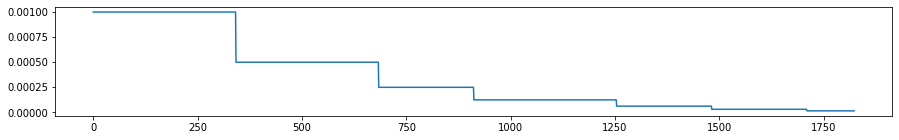


**********
fold-1
trainable parameters: 6037249
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5465480878687742, val_loss:0.5309163789663996, val_score:0.855527304531491

Epoch2　train_loss:0.5342414698057008, val_loss:0.5295623029981341, val_score:0.8555217508994755
    score did not impove from 0.855527304531491 (now 1 consecutive)

Epoch3　train_loss:0.5331974839955046, val_loss:0.52884434482881, val_score:0.8560635448650674

Epoch4　train_loss:0.5324443082014719, val_loss:0.5281180143356323, val_score:0.8573503792266932

Epoch5　train_loss:0.5327260439333162, val_loss:0.5292414203286171, val_score:0.8549569785258034
    score did not impove from 0.8573503792266932 (now 1 consecutive)

Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.
Epoch6　train_loss:0.5321003967209866, val_loss:0.5294160544872284, val_score:0.8568118529443035
    score did not impove from 0.8573503792266932 (now 2 consecutive)

Epoch7　train_loss:0.5311343727404612, val_loss:0.5276657534497124, val_score:0.8571785442325575
    score did not impove from 0.8573503792266932 (now 3 c

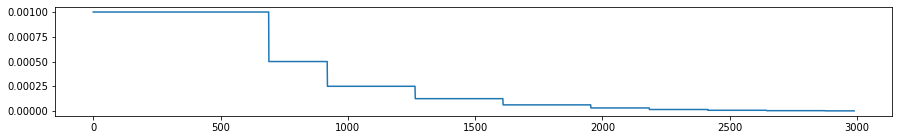


**********
fold-2
trainable parameters: 6037249
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.54480842256968, val_loss:0.5357915060273533, val_score:0.8556462687764201

Epoch2　train_loss:0.5332848643307138, val_loss:0.5333410737843349, val_score:0.8579528227726798

Epoch3　train_loss:0.5313989902492118, val_loss:0.533587229662928, val_score:0.8579065598808662
    score did not impove from 0.8579528227726798 (now 1 consecutive)

Epoch 00004: reducing learning rate of group 0 to 5.0000e-04.
Epoch4　train_loss:0.5311231069860205, val_loss:0.5351145966299649, val_score:0.8557416346643191
    score did not impove from 0.8579528227726798 (now 2 consecutive)

Epoch5　train_loss:0.5306576609084036, val_loss:0.5331726783308489, val_score:0.857803680058729
    score did not impove from 0.8579528227726798 (now 3 consecutive)

Epoch 00006: reducing learning rate of group 0 to 2.5000e-04.
Epoch6　train_loss:0.5304032055150091, val_loss:0.532667019243898, val_score:0.8575776489448671
    score did not impove from 0.8579528227726798 (now 4 consecutive)

Epoch7　train_loss:0.529

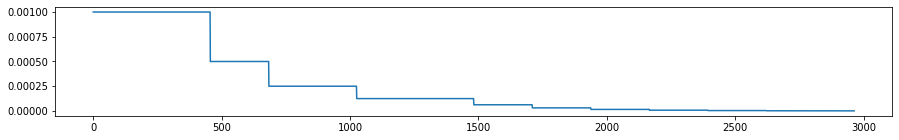


**********
fold-3
trainable parameters: 6037249
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5435809712660941, val_loss:0.5260281737508445, val_score:0.8562577899192856

Epoch2　train_loss:0.534548013356694, val_loss:0.5258800068805958, val_score:0.8549540413649459
    score did not impove from 0.8562577899192856 (now 1 consecutive)

Epoch 00003: reducing learning rate of group 0 to 5.0000e-04.
Epoch3　train_loss:0.5336110803641771, val_loss:0.5252909331486143, val_score:0.8562635378300529

Epoch4　train_loss:0.5318340235634854, val_loss:0.5240003487159466, val_score:0.8582228395245587

Epoch5　train_loss:0.53179879094425, val_loss:0.5269007528650349, val_score:0.8572463619622513
    score did not impove from 0.8582228395245587 (now 1 consecutive)

Epoch 00006: reducing learning rate of group 0 to 2.5000e-04.
Epoch6　train_loss:0.5317911435114709, val_loss:0.524261666782971, val_score:0.8582408525702794

Epoch7　train_loss:0.5311565684121952, val_loss:0.5238702718553871, val_score:0.8579695889519547
    score did not impove from 0.8582408525702794 (now 1 consecut

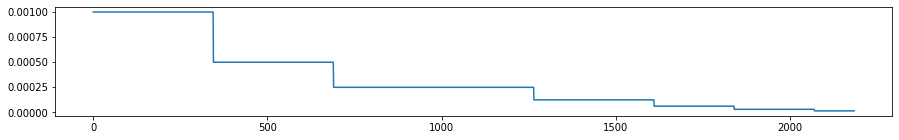


**********
fold-4
trainable parameters: 6037249
untrainable parameters: 0


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch1　train_loss:0.5420008423054112, val_loss:0.5360466063022613, val_score:0.8412952190689009

Epoch2　train_loss:0.5324466326067933, val_loss:0.5367677330970764, val_score:0.8414338124851499

Epoch3　train_loss:0.5316391154728105, val_loss:0.5372778087854385, val_score:0.8418411368792882

Epoch4　train_loss:0.5314290275615928, val_loss:0.534515592455864, val_score:0.8426875011293902

Epoch5　train_loss:0.5308417640956102, val_loss:0.5356322973966599, val_score:0.8416297414862886
    score did not impove from 0.8426875011293902 (now 1 consecutive)

Epoch6　train_loss:0.53071001145692, val_loss:0.5346574306488037, val_score:0.8430316216922921

Epoch7　train_loss:0.5303808144763508, val_loss:0.5348943054676056, val_score:0.8419039396819074
    score did not impove from 0.8430316216922921 (now 1 consecutive)

Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.
Epoch8　train_loss:0.5309042236973754, val_loss:0.5352685312430064, val_score:0.8417072473795768
    score did not impove fro

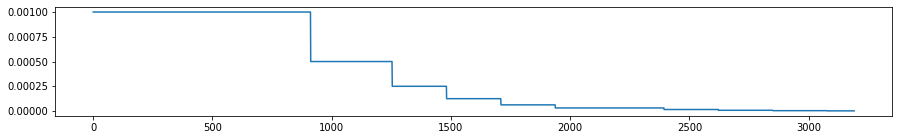


CV Score: 0.8540719420958109


In [ ]:
df_oof = df.copy()

for i in range(5):

    print('--'*10)
    print(f'nn-{i}')

    CFG.seed += 1

    path = os.path.join(CFG.OUTPUT_DIR, f'STACKING_seed{CFG.seed}_MODEL/')

    if not os.path.exists(path):
        os.makedirs(path)

    df = create_folds(df, CFG.num_fold, CFG.seed)
    display(df.head())
    display(df.groupby('fold').size())

    fig, ax = plt.subplots()
    for i in range(CFG.num_fold):
      ax.hist(df.loc[df['fold']==i, 'score'], alpha=0.2, label=f'fold{i}')
    ax.legend()
    plt.show()

    for fold in range(CFG.num_fold):

        print('*'*10)
        print(f'fold-{fold}')

        train = df[df['fold']!=fold]
        valid = df[df['fold']==fold]
        
        oof = np.zeros(len(train))
        test_preds_lst = []

        train_dset = StackingDataset_2Dcnn(train, feat_cols_cnn[5+i])
        valid_dset = StackingDataset_2Dcnn(valid, feat_cols_cnn[5+i])

        train_loader = DataLoader(train_dset, batch_size=CFG.BATCH_SIZE, pin_memory=True, shuffle=True, drop_last=True, num_workers=os.cpu_count())
        valid_loader = DataLoader(valid_dset, batch_size=CFG.BATCH_SIZE, pin_memory=True, shuffle=False, drop_last=False, num_workers=os.cpu_count())

        model = StackingModel_2Dcnn(CFG)
        model.to(CFG.DEVICE)

        model_path = os.path.join(path, f'base_fold{fold}.bin')

        trainable_num = 0
        untrainable_num = 0
        for p in model.parameters():
            if p.requires_grad:
                trainable_num += p.numel()
            else:
                untrainable_num += p.numel()
                
        print(f'trainable parameters: {trainable_num}')
        print(f'untrainable parameters: {untrainable_num}')
        
        optimizer = torch.optim.AdamW(model.parameters())
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, verbose=True)
                    
        valid_best_score = float('-999')
        counter = 0

        lr_list = []

        for epoch in tqdm(range(CFG.N_EPOCHS)):
            train_loss, lrs = train_loop(model, optimizer, scheduler, train_loader)
            valid_loss, valid_predict = valid_loop(model, valid_loader)

            valid['oof'] = valid_predict

            val_score = np.corrcoef(valid['oof'], valid[target_col])[0][1]

            scheduler.step(val_score)

            print(f'Epoch{epoch+1}　train_loss:{train_loss}, val_loss:{valid_loss}, val_score:{val_score}')

            if val_score > valid_best_score:
                valid_best_score = val_score
                counter = 0
                torch.save(model.state_dict(), model_path)

            else:
                counter += 1
                print(f'    score did not impove from {valid_best_score} (now {counter} consecutive)')

            # plt.figure(figsize=(15, 2))
            # plt.plot(lrs)
            # plt.show()

            lr_list.append(np.mean(lrs))
            lr_list.extend(lrs)

            print('')

            torch.cuda.empty_cache()
            gc.collect()

            if counter > 6:
              print(f'Fold{fold} Epoch{epoch+1} Early Stopping')
              print(f'best_score: {valid_best_score}')
              print('')
              break
        
        print(f'Fold{fold} best_score: {valid_best_score}')

        plt.figure(figsize=(15, 2))
        plt.plot(lr_list)
        plt.show()
        print('')

        model.load_state_dict(torch.load(model_path))
        df_oof.loc[df['fold']==fold, f'oof'] = test_loop(model, valid_loader)

    score = np.corrcoef(df_oof['oof'], df_oof[target_col])[0][1]
    df_oof.to_pickle('2dcnn.pkl')
    print(f'CV Score: {score}')

In [ ]:
df_oof

,id,anchor,target,context,score,preds_0,preds_1,preds_2,preds_3,preds_4,preds_5,fold,oof
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,0.466284,0.510132,0.317783,0.416120,0.462182,0.146545,4,0.346249
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,0.722547,0.575757,0.713420,0.545296,0.637189,0.604272,4,0.626173
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,0.117356,0.258999,0.243357,0.281782,0.258671,0.226358,4,0.228445
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,0.549443,0.625390,0.510812,0.510402,0.562911,0.526696,4,0.536073
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,0.021158,0.013692,0.044547,0.083340,0.087163,0.071804,4,0.030688
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00,0.993340,0.988504,0.983815,0.989919,0.977054,0.797394,2,0.982295
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50,0.468818,0.495762,0.481736,0.503225,0.433811,0.400614,2,0.469792
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50,0.473872,0.463800,0.445182,0.440896,0.384114,0.412725,2,0.441590
36471,756ec035e694722b,wood article,wooden material,B44,0.75,0.733905,0.645317,0.709172,0.672722,0.642667,0.591164,2,0.677669


In [ ]:
df_oof[df_oof['score'] == 0.75]

,id,anchor,target,context,score,preds_0,preds_1,preds_2,preds_3,preds_4,preds_5,fold,oof
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,0.722547,0.575757,0.713420,0.545296,0.637189,0.604272,4,0.626173
73,80126fcecd1c57c9,abnormal position,abnormal placement,D03,0.75,0.731191,0.733864,0.740377,0.731565,0.723658,0.663121,1,0.710599
74,0ff1349355ce5b66,abnormal position,abnormal posture,D03,0.75,0.651852,0.608598,0.733533,0.609925,0.686714,0.602659,1,0.653678
76,3e410ad7a4a355ff,abnormal position,abnormal side,D03,0.75,0.447325,0.557548,0.524214,0.416980,0.561149,0.495667,1,0.500927
86,29de10bbd3f15b11,abnormal position,odd position,D03,0.75,0.654074,0.317991,0.687020,0.698788,0.304864,0.632084,1,0.626891
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36455,4c6c4f4cd02bef2a,wood article,lumber article,B44,0.75,0.832140,0.739799,0.713565,0.823248,0.721604,0.700110,2,0.745990
36460,4f366b6369dbfbf2,wood article,timber article,B44,0.75,0.838904,0.840383,0.728902,0.821085,0.856035,0.671088,2,0.771230
36461,2cac15df9f918089,wood article,timber product,B44,0.75,0.742151,0.770444,0.683984,0.633719,0.697627,0.559796,2,0.678732
36466,8a57100f6ee40ffc,wood article,wood material,B44,0.75,0.744279,0.634924,0.699356,0.659153,0.640251,0.626001,2,0.677460


In [ ]:
plt.hist(df_oof[['score','oof']],bins=1000)
plt.title('Ensemble OOF predictions')
plt.show()

In [ ]:
plt.hist(df_oof[['score','ensambled']],bins=1000)
plt.title('Ensemble OOF predictions')
plt.show()